In [13]:
import pandas as pd
import numpy as np
import re
import random
from sklearn.utils import shuffle
import tensorflow as tf
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from afinn import Afinn
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Input
import tensorflow_hub as hub

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from transformers import BertTokenizer, TFBertModel
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras import layers, models, optimizers
from itertools import product
from imblearn.over_sampling import SMOTE
from transformers import BertTokenizer
from itertools import product
import csv
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Activation

from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

from tensorflow.keras import layers, models, optimizers
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder

from keras_tuner import GridSearch as kt

#Import data
parlvote = pd.read_csv('ParlVote_concat.csv', header=None)
first_row = parlvote.iloc[0].tolist()
parlvote.columns = first_row
parlvote = parlvote.drop(index=0)

#########################BEGIN SAMPLE##################################
#parlvote =  parlvote.sample(n=300, random_state=42)
##########################END SAMPLE###################################

### Train for domain specific lexion ####
# Preprocess
# Download necessary resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the set of stopwords
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    # Tokenize and lowercase
    tokens = word_tokenize(text.lower())
    
    # Remove stopwords and lemmatize
    return [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and token.isalpha()]

# Apply preprocessing to the 'speech' column and store the result in 'speech_processed'
parlvote['speech_processed'] = parlvote['speech'].apply(preprocess_text)

parlvote['speech_svm'] = parlvote['speech_processed'].apply(' '.join)

# Train Word2Vec model
model = Word2Vec(parlvote['speech_processed'], vector_size=300, window=6, min_count=10, workers=4)
model.train(parlvote['speech_processed'], total_examples=len(parlvote['speech_processed']), epochs=5)

######## REMOVE speeches with >512 tokens ##########
rem_token = []
sh_pv_before = parlvote.shape

## Instantiate a BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")


# Tokenize the speeches and count tokens
parlvote['token_length'] = parlvote['speech'].apply(lambda x: len(tokenizer.tokenize(x)))

# Filter out rows with more than 512 tokens
max_tokens = 512
parlvote = parlvote[parlvote['token_length'] <= max_tokens]

# Now 'filtered_parlvote' is a DataFrame containing only rows with no more than 512 BERT tokens in the 'speech' column
# Shape after removing neutral
sh_pv_after = parlvote.shape
rem_token.append({"original" : sh_pv_before, ">512 removed" : sh_pv_after})
rem_token_df = pd.DataFrame(rem_token)

# Save the new DataFrame to a CSV file
rem_token_df.to_csv("removed_512.csv", index=False)


##### GENERATE SENTIMENT LABELS ########
### Domain Specific ####


def sentiment_score(speech, model, positive_seeds, negative_seeds):
    # Tokenize the speech
    words = speech.split()
    
    score = 0
    for word in words:
        if word in model.wv:
            word_vector = model.wv[word]
            
            # Sum of cosine similarities with positive seed words
            for seed in positive_seeds:
                if seed in model.wv:
                    seed_vector = model.wv[seed]
                    score += np.dot(word_vector, seed_vector) / (np.linalg.norm(word_vector) * np.linalg.norm(seed_vector))
                    
            # Subtract sum of cosine similarities with negative seed words
            for seed in negative_seeds:
                if seed in model.wv:
                    seed_vector = model.wv[seed]
                    score -= np.dot(word_vector, seed_vector) / (np.linalg.norm(word_vector) * np.linalg.norm(seed_vector))
    
    return score

positive_seeds = ["good", "excellent", "correct", "best", "happy", "positive", "fortunate"]
negative_seeds = ["bad", "terrible", "wrong", "worst", "disappointed", "negative", "unfortunate"]

# Generate raw sentiment scores
raw_sentiment_scores = [sentiment_score(speech, model, positive_seeds, negative_seeds) for speech in parlvote['speech']]

# Reshape the scores to fit the scaler input
raw_sentiment_scores = np.array(raw_sentiment_scores).reshape(-1, 1)

# Create a MinMaxScaler object with feature range of -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit the scaler to the data and transform the data
scaled_sentiment_scores = scaler.fit_transform(raw_sentiment_scores)

# Create 'domain_sentiment' column in the parlvote dataframe
parlvote['domain_sentiment'] = scaled_sentiment_scores.flatten()


###### BREAK #########
# if 1 == 1:
#     raise ValueError("Stopping execution at this cell")


### Standard Lexicons ###

# Initialize sentiment analyzers
vader_analyzer = SentimentIntensityAnalyzer()
afinn_analyzer = Afinn()
textblob_analyzer = TextBlob

# Define a function to generate the sentiment scores for each row
def generate_sentiment_scores(row):
    text = row['speech']
    
    # Generate VADER sentiment score
    vader_scores = vader_analyzer.polarity_scores(text)['compound']
    
    # Generate Afinn sentiment score
    afinn_score = afinn_analyzer.score(text)
    
    # Generate TextBlob sentiment score
    textblob_score = textblob_analyzer(text).sentiment.polarity
    
    return pd.Series([vader_scores, textblob_score, afinn_score])


# Apply the function to generate sentiment scores for each row and store the scores in new columns
parlvote[['vader', 'textblob', 'afinn']] = parlvote.apply(generate_sentiment_scores, axis=1)


# Define a function to convert VADER sentiment scores to labels
def vader_score_to_label(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Define a function to convert TextBlob sentiment scores to labels
def textblob_score_to_label(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

# Define a function to convert Afinn sentiment scores to labels
def afinn_score_to_label(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'


# Apply the label conversion functions to the sentiment score columns
parlvote['vader'] = parlvote['vader'].apply(vader_score_to_label)
parlvote['textblob'] = parlvote['textblob'].apply(textblob_score_to_label)
parlvote['afinn'] = parlvote['afinn'].apply(afinn_score_to_label)
parlvote['domain_sentiment'] = parlvote['domain_sentiment'].apply(textblob_score_to_label)

######### REMOVE 'NEUTRAL' LABELS #########
# Shape before removing neutral
removed = []
before = parlvote.shape

# remove instances where a row contains 'neutral'
pv = parlvote.loc[~((parlvote['vader'] == 'Neutral') | (parlvote['textblob'] == 'Neutral') | (parlvote['afinn'] == 'Neutral') | (parlvote['domain_sentiment'] == 'Neutral'))]
# Create a copy of the DataFrame to avoid modifying the original DataFrame
pv = pv.copy()

# Shape after removing neutral
after = pv.shape
removed.append({"original" : before, "neutral removed" : after})
removed_df = pd.DataFrame(removed)

# Save the new DataFrame to a CSV file
removed_df.to_csv("removed_neutral.csv", index=False)


######## CHANGE TO BINARY #########
def label_to_binary(label):
    if label == 'Positive':
        return 1
    else:
        return 0


def str_to_int(label):
    if label == '1':
        return 1
    else:
        return 0


# Convert sentiment labels to binary values for 'vader', 'textblob', and 'afinn' columns
pv['vader'] = pv['vader'].apply(label_to_binary)
pv['textblob'] = pv['textblob'].apply(label_to_binary)
pv['afinn'] = pv['afinn'].apply(label_to_binary)
pv['domain_sentiment'] = pv['domain_sentiment'].apply(label_to_binary)

# Convert the string of 'vote' to integer
pv['vote'] = pv['vote'].apply(str_to_int)


####### EMBEDDINGS ########
# Load a pre-trained BERT model
embedding_model = SentenceTransformer('bert-base-cased')
# Generate embeddings for the 'speech' column
pv['embeddings'] = parlvote['speech'].apply(lambda x: embedding_model.encode(x, convert_to_numpy=True))
print("Shape of the first embedding: ", pv['embeddings'].iloc[0].shape)
# Now 'parlvote' has a new column 'embeddings' containing the embeddings as numpy arrays


# Define the label columns
label_columns = ["vote", "vader", "textblob", "afinn", "domain_sentiment"]

# Initialize an empty dictionary to store the distributions
distributions = {}

# For each label column, compute the distribution and store it in the dictionary
for label in label_columns:
    distributions[label] = pv[label].value_counts(normalize=True) * 100

# Convert the distributions dictionary into a DataFrame
distributions_df = pd.DataFrame(distributions)

# Transpose the DataFrame so that each row corresponds to a label
distributions_df = distributions_df.transpose()

# Save the distributions DataFrame to a CSV file
distributions_df.to_csv("distributions.csv")


###### ONE-HOT ENCODE PV (train-val) AND PV_TEST #######
# Define a function to one-hot encode a column
def one_hot_encode(df, column):
    df[column + '_positive'] = (df[column] == 1).astype(int)
    df[column + '_negative'] = (df[column] == 0).astype(int)
    return df


# Apply the function to one-hot encode the columns in the 'pv' dataframe
pv = one_hot_encode(pv, 'vote')
pv = one_hot_encode(pv, 'vader')
pv = one_hot_encode(pv, 'textblob')
pv = one_hot_encode(pv, 'afinn')
pv = one_hot_encode(pv, 'domain_sentiment')

# # Apply the function to one-hot encode the columns in the 'pv_test' dataframe
# pv_test = one_hot_encode(pv_test, 'vote')
# pv_test = one_hot_encode(pv_test, 'vader')
# pv_test = one_hot_encode(pv_test, 'textblob')
# pv_test = one_hot_encode(pv_test, 'afinn')
# pv_test = one_hot_encode(pv_test, 'domain_sentiment')

# # Prepare sliding window and sentence embedding functions
# def sliding_window(text, window_size, stride):
#     num_chunks = max((len(text) - window_size) // stride + 1, 1)
#     chunks = [text[i*stride:i*stride + window_size] for i in range(num_chunks)]
#     return chunks


# def get_sentence_embeddings(embedding_model, data, max_length, window_size, stride, aggregation='mean'):
#     all_embeddings = []
    
#     for text in data:
#         if len(text) > max_length:
#             chunks = sliding_window(text, window_size, stride)
#         else:
#             chunks = [text]

#         # Generate embeddings for each chunk
#         chunk_embeddings = embedding_model.encode(chunks)
        
#         # Aggregate the embeddings
#         if aggregation == 'mean':
#             aggregated_embedding = np.mean(chunk_embeddings, axis=0)
#         elif aggregation == 'max':
#             aggregated_embedding = np.max(chunk_embeddings, axis=0)
#         elif aggregation == 'min':
#             aggregated_embedding = np.min(chunk_embeddings, axis=0)
#         else:
#             raise ValueError(f"Unsupported aggregation method: {aggregation}")

#         all_embeddings.append(aggregated_embedding)

#     return np.array(all_embeddings)

# # Set the parameters for the sliding window
# max_length = 512
# window_size = 400
# stride = 200

def print_majority_baselines(df, one_hot_encoded_columns):
    for columns in one_hot_encoded_columns:
        majority_class = df[columns].sum(axis=0).idxmax()
        majority_baseline = df[majority_class].mean()
        
        print(f"Majority baseline for {', '.join(columns)}:")
        print(f"  Majority class: {majority_class}")
        print(f"  Baseline accuracy: {majority_baseline:.2%}\n")

# usage
one_hot_encoded_columns = [
    ['vote_positive', 'vote_negative'],
    ['vader_positive', 'vader_negative'],
    ['textblob_positive', 'textblob_negative'],
    ['afinn_positive', 'afinn_negative'], 
    ['domain_sentiment_positive', 'domain_sentiment_negative']
]

backup = pv.copy()
##### LABEL DISTRIBUTIONS #######
# Randomly sample 20% of ParlVote for Test set
pv_test = pv.sample(frac=0.20, random_state=1)

# Drop these rows from the original DataFrame to create the train_val DataFrame
pv= pv.drop(pv_test.index)


# Randomly sample 20% of ParlVote for Validation set
pv_val = pv.sample(frac=0.20, random_state=1)

# Drop these rows from the original DataFrame to create the train_val DataFrame
pv = pv.drop(pv_val.index)


##### PRINT MAJORITY BASELINES FOR PV ######
print_majority_baselines(pv, one_hot_encoded_columns)

#### PRINT MAJORITY BASELINES FOR PV_TEST #####
def majority_baseline(df, columns):
        majority_class = df[columns].sum(axis=0).idxmax()
        majority_baseline = df[majority_class].mean()
        return majority_baseline

vote_majority = majority_baseline(pv_test, one_hot_encoded_columns[0])
vader_majority = majority_baseline(pv_test, one_hot_encoded_columns[1])
textblob_majority = majority_baseline(pv_test, one_hot_encoded_columns[2])
afinn_majority = majority_baseline(pv_test, one_hot_encoded_columns[3])
domain_majority = majority_baseline(pv_test, one_hot_encoded_columns[4])

# Convert one-hot encoded columns to a NumPy array
vote_labels = pv[['vote_positive', 'vote_negative']].values
vader_labels = pv[['vader_positive', 'vader_negative']].values
textblob_labels = pv[['textblob_positive', 'textblob_negative']].values
afinn_labels = pv[['afinn_positive', 'afinn_negative']].values
domain_labels = pv[['domain_sentiment_positive', 'domain_sentiment_negative']].values

# Convert one-hot encoded columns to a NumPy array
vote_labels_test = pv_test[['vote_positive', 'vote_negative']].values
vader_labels_test = pv_test[['vader_positive', 'vader_negative']].values
textblob_labels_test = pv_test[['textblob_positive', 'textblob_negative']].values
afinn_labels_test = pv_test[['afinn_positive', 'afinn_negative']].values
domain_labels_test = pv_test[['domain_sentiment_positive', 'domain_sentiment_negative']].values


# Convert one-hot encoded columns to a NumPy array
vote_labels_val = pv_val[['vote_positive', 'vote_negative']].values
vader_labels_val = pv_val[['vader_positive', 'vader_negative']].values
textblob_labels_val = pv_val[['textblob_positive', 'textblob_negative']].values
afinn_labels_val = pv_val[['afinn_positive', 'afinn_negative']].values
domain_labels_val = pv_val[['domain_sentiment_positive', 'domain_sentiment_negative']].values



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\beren\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\beren\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\beren\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
No sentence-transformers model found with name C:\Users\beren/.cache\torch\sentence_transformers\bert-base-cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\beren/.cache\torch\sentence_transformers\bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_re

Shape of the first embedding:  (768,)
Majority baseline for vote_positive, vote_negative:
  Majority class: vote_positive
  Baseline accuracy: 53.80%

Majority baseline for vader_positive, vader_negative:
  Majority class: vader_positive
  Baseline accuracy: 77.38%

Majority baseline for textblob_positive, textblob_negative:
  Majority class: textblob_positive
  Baseline accuracy: 83.73%

Majority baseline for afinn_positive, afinn_negative:
  Majority class: afinn_positive
  Baseline accuracy: 71.97%

Majority baseline for domain_sentiment_positive, domain_sentiment_negative:
  Majority class: domain_sentiment_negative
  Baseline accuracy: 76.26%



In [ ]:
def plot_overlap(df, col1_positive, col1_negative, col2_positive, col2_negative):
    # Combine positive and negative labels into binary labels for col1 and col2
    col1_labels = df[col1_positive] - df[col1_negative]
    col2_labels = df[col2_positive] - df[col2_negative]

    # Generate confusion matrix
    cm = confusion_matrix(col1_labels, col2_labels)

    # Display confusion matrix
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues', cbar=False)
    plt.ylabel('Vote label')
    plt.xlabel('Automatic label')
    plt.title('Overlap between Vote and {}'.format(col2_positive.split('_')[0]), size = 15)
    plt.show()

# Loop over the other methods
for method in ['vader', 'textblob', 'afinn', 'domain_sentiment']:
    plot_overlap(backup, 'vote_positive', 'vote_negative', f'{method}_positive', f'{method}_negative')

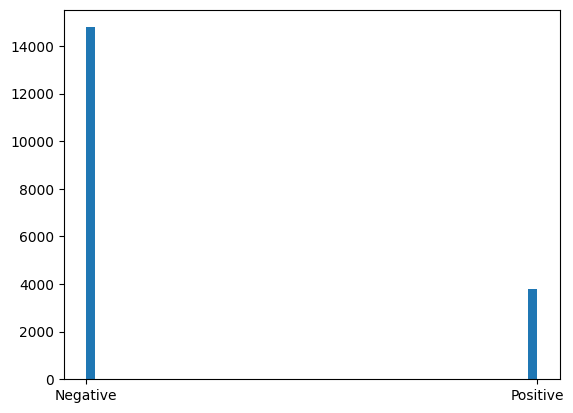

In [14]:
plt.hist(parlvote['domain_sentiment'], bins=50)
plt.show()

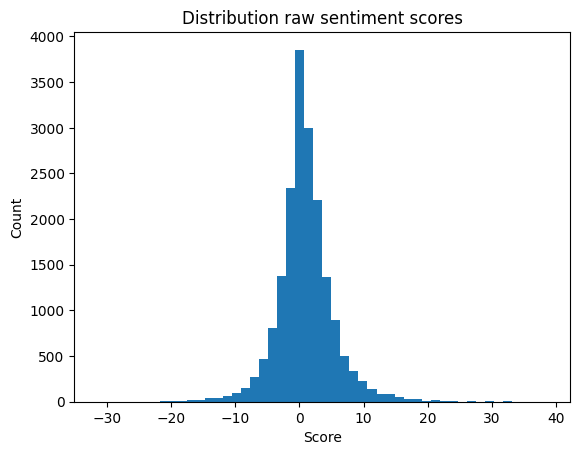

In [15]:
import matplotlib.pyplot as plt

plt.hist(raw_sentiment_scores, bins=50)
plt.title("Distribution raw sentiment scores")
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

## HYPERPARAMETER OPTIMIZATION 

In [16]:
####### SETUP MODEL ########
data = pv['embeddings']

In [17]:
type(data)

pandas.core.series.Series

In [18]:
# Convert data series to NumPy array
data = np.stack(data, axis=0)  # Convert the lists of embeddings to a NumPy array


In [19]:
######## HYPERMODEL FOR VOTE (different dropout) #######
class SentimentAnalysisHyperModel_1(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = models.Sequential()
        model.add(layers.Input(shape=self.input_shape))
        model.add(layers.Reshape((1, self.input_shape[0])))
        model.add(layers.SpatialDropout1D(0.3)),
        model.add(layers.Bidirectional(layers.LSTM(units=hp.Choice('lstm_units', values=[32, 64, 128, 512]),
                                               dropout=0.3, recurrent_dropout=0.3)))
        model.add(layers.Dense(units=hp.Choice('dense_units', values=[32, 64, 128, 512]), activation='relu'))
        model.add(layers.Dropout(0.4))
        model.add(layers.Dense(self.num_classes, activation='softmax'))

        model.compile(optimizer=optimizers.Adam(hp.Choice('learning_rate', values=[0.001, 0.0001])),
              loss='categorical_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall')
              ])

        return model

In [20]:
import json

In [21]:

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [22]:
### DEDICATED VAL SET
# Store validation data
x_val = pv_val['embeddings']
# Convert x_val series to NumPy array
x_val = np.stack(x_val, axis=0)  # Convert the lists of embeddings to a NumPy array


In [23]:
######## HPO 'Vote' ########

input_shape = (data.shape[1],)
num_classes = vote_labels.shape[1]

hypermodel_1 = SentimentAnalysisHyperModel_1(input_shape, num_classes)


tuner_vote = kt(
    hypermodel_1,
    objective='val_accuracy',
    max_trials=48,
    executions_per_trial=3,
    directory='output',
    project_name='sentiment_analysis_vote')


tuner_vote.search(x=data,
             y=vote_labels,
             epochs=10,
             validation_split=0.2)

# Save best HPS
best_hps_vote = tuner_vote.get_best_hyperparameters(num_trials=1)[0]
best_hps_str_vote = json.dumps(best_hps_vote.values)

# Build  with best HPS
model_vote = tuner_vote.hypermodel.build(best_hps_vote)

# and train model
history_vote = model_vote.fit(data, vote_labels, epochs=50, validation_data=(x_val, vote_labels_val), callbacks=[early_stopping])

# Save model with best HPS
model_vote.save('best_model_vote.h5')

# Get the performance metrics from the last epoch
performance_vote = {
    'accuracy': history_vote.history['val_accuracy'][-1],
    'precision': history_vote.history['val_precision'][-1],
    'recall': history_vote.history['val_recall'][-1],
    'best_param' : best_hps_str_vote
}

# Save as dataframe
performance_df_vote = pd.DataFrame([performance_vote])
performance_df_vote.to_csv('performance_vote.csv', index=False)

INFO:tensorflow:Reloading Tuner from output\sentiment_analysis_vote\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
308/308 [==============================] - 9s 13ms/step - loss: 0.6921 - accuracy: 0.5273 - precision: 0.5273 - recall: 0.5273 - val_loss: 0.6894 - val_accuracy: 0.5412 - val_precision: 0.5412 - val_recall: 0.5412
Epoch 2/50
308/308 [==============================] - 3s 10ms/step - loss: 0.6900 - accuracy: 0.5359 - precision: 0.5359 - recall: 0.5359 - val_loss: 0.6881 - val_accuracy: 0.5412 - val_precision: 0.5412 - val_recall: 0.5412
Epoch 3/50
308/308 [==============================] - 3s 11ms/step - loss: 0.6896 - accuracy: 0.5366 - precision: 0.5366 - recall: 0.5366 - val_loss: 0.6868 - val_accuracy: 0.5416 - val_precision: 0.5416 - val_recall: 0.5416
Epoch 4/50
308/308 [==============================] - 3s 10ms/step - loss: 0.6881 - accuracy: 0.5365 - precision: 0.5365 - recall: 0.5365 - val_loss: 0.6870 - val_accuracy: 0.5412 - val_precision: 0.5412 - v

In [24]:
performance_df_vote

,accuracy,precision,recall,best_param
0,0.558262,0.558262,0.558262,"{""lstm_units"": 64, ""learning_rate"": 0.00072253..."


In [25]:
###### HYPERMODEL FOR AUTOMATIC SENTIMENT LABELS (differen dropout) #########
class SentimentAnalysisHyperModel_2(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = models.Sequential()
        model.add(layers.Input(shape=self.input_shape))
        model.add(layers.Reshape((1, self.input_shape[0])))
        model.add(layers.SpatialDropout1D(0.2)),
        model.add(layers.Bidirectional(layers.LSTM(units=hp.Choice('lstm_units', values=[64, 128, 512]),
                                               dropout=0.2, recurrent_dropout=0.2)))
        model.add(layers.Dense(units=hp.Choice('dense_units', values=[64, 128, 512]), activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(self.num_classes, activation='softmax'))

        model.compile(optimizer=optimizers.Adam(hp.Choice('learning_rate', values=[0.001, 0.0001])),
              loss='categorical_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall')
              ])

        return model

In [26]:
import json

In [27]:
######## HPO 'VADER' ########
input_shape = (data.shape[1],)
num_classes = vader_labels.shape[1]

hypermodel_2 = SentimentAnalysisHyperModel_2(input_shape, num_classes)

tuner_vader = kt(
    hypermodel_2,
    objective='val_accuracy',
    max_trials=48,
    executions_per_trial=3,
    directory='output',
    project_name='sentiment_analysis_vader')

tuner_vader.search(x=data,
             y=vader_labels,
             epochs=10,
             validation_split=0.2)

# Save best HPS
best_hps_vader = tuner_vader.get_best_hyperparameters(num_trials=1)[0]
best_hps_vader_str = json.dumps(best_hps_vader.values)

# Build and train model with best HPS
model_vader = tuner_vader.hypermodel.build(best_hps_vader)
history_vader = model_vader.fit(data, vader_labels, epochs=50, validation_data=(x_val, vader_labels_val), callbacks=[early_stopping])

# Save model with best HPS
model_vader.save('best_model_vader.h5')

# Get the performance metrics from the last epoch
performance_vader = {
    'accuracy': history_vader.history['val_accuracy'][-1],
    'precision': history_vader.history['val_precision'][-1],
    'recall': history_vader.history['val_recall'][-1],
    'best_param' : best_hps_vader_str
}

# Save as dataframe
performance_df_vader = pd.DataFrame([performance_vader])
performance_df_vader.to_csv('performance_vader.csv', index=False)


INFO:tensorflow:Reloading Tuner from output\sentiment_analysis_vader\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
308/308 [==============================] - 10s 15ms/step - loss: 0.5429 - accuracy: 0.7715 - precision: 0.7715 - recall: 0.7715 - val_loss: 0.5215 - val_accuracy: 0.7698 - val_precision: 0.7698 - val_recall: 0.7698
Epoch 2/50
308/308 [==============================] - 4s 13ms/step - loss: 0.5148 - accuracy: 0.7738 - precision: 0.7738 - recall: 0.7738 - val_loss: 0.4982 - val_accuracy: 0.7698 - val_precision: 0.7698 - val_recall: 0.7698
Epoch 3/50
308/308 [==============================] - 4s 13ms/step - loss: 0.4869 - accuracy: 0.7741 - precision: 0.7741 - recall: 0.7741 - val_loss: 0.4722 - val_accuracy: 0.7706 - val_precision: 0.7706 - val_recall: 0.7706
Epoch 4/50
308/308 [==============================] - 4s 13ms/step - loss: 0.4717 - accuracy: 0.7784 - precision: 0.7784 - recall: 0.7784 - val_loss: 0.4485 - val_accuracy: 0.7812 - val_precision: 0.7812 -

In [28]:
# Load version 2 with different dropout rates for VADER

# Load the previously saved model
model = load_model('best_model_vader.h5')

# Modify the dropout rates
model.layers[2].rate = 0.3  # SpatialDropout1D rate
model.layers[3].dropout = 0.3  # Bidirectional LSTM dropout rate
model.layers[5].rate = 0.3  # Dense dropout rate

# Build and train model with best HPS
history_vader_v2 = model.fit(data, vader_labels, epochs=50, validation_data=(x_val, vote_labels_val), callbacks=[early_stopping])

# Save the modified model as a new version
model.save('best_model_vader_v2.h5')

# Get the performance metrics from the last epoch
performance_vader_v2 = {
    'accuracy': history_vader_v2.history['val_accuracy'][-1],
    'precision': history_vader_v2.history['val_precision'][-1],
    'recall': history_vader_v2.history['val_recall'][-1],
    'best_param' : best_hps_vader_str
}

# Save as dataframe
performance_df_vader_v2 = pd.DataFrame([performance_vader_v2])
performance_df_vader_v2.to_csv('performance_vader_v2.csv', index=False)

Epoch 1/50
308/308 [==============================] - 8s 16ms/step - loss: 0.3948 - accuracy: 0.8206 - precision: 0.8206 - recall: 0.8206 - val_loss: 1.1918 - val_accuracy: 0.5262 - val_precision: 0.5262 - val_recall: 0.5262
Epoch 2/50
308/308 [==============================] - 4s 14ms/step - loss: 0.3924 - accuracy: 0.8200 - precision: 0.8200 - recall: 0.8200 - val_loss: 1.2817 - val_accuracy: 0.5250 - val_precision: 0.5250 - val_recall: 0.5250
Epoch 3/50
308/308 [==============================] - 4s 14ms/step - loss: 0.3922 - accuracy: 0.8221 - precision: 0.8221 - recall: 0.8221 - val_loss: 1.2372 - val_accuracy: 0.5262 - val_precision: 0.5262 - val_recall: 0.5262
Epoch 4/50
308/308 [==============================] - 4s 13ms/step - loss: 0.3963 - accuracy: 0.8203 - precision: 0.8203 - recall: 0.8203 - val_loss: 1.1927 - val_accuracy: 0.5242 - val_precision: 0.5242 - val_recall: 0.5242
Epoch 5/50
308/308 [==============================] - 4s 14ms/step - loss: 0.3968 - accuracy: 0.8169

In [29]:
######## HPO 'TextBlob' ########
input_shape = (data.shape[1],)
num_classes = textblob_labels.shape[1]

hypermodel_2 = SentimentAnalysisHyperModel_2(input_shape, num_classes)

tuner_textblob = kt(
    hypermodel_2,
    objective='val_accuracy',
    max_trials=48,
    executions_per_trial=3,
    directory='output',
    project_name='sentiment_analysis_textblob')

tuner_textblob.search(x=data,
             y=textblob_labels,
             epochs=10,
             validation_split=0.2)

# Save best HPS
best_hps_textblob = tuner_textblob.get_best_hyperparameters(num_trials=1)[0]
best_hps_textblob_str = json.dumps(best_hps_textblob.values)

# Build and train model with best HPS
model_textblob = tuner_textblob.hypermodel.build(best_hps_textblob)
history_textblob = model_textblob.fit(data, textblob_labels, epochs=50, validation_data=(x_val, textblob_labels_val), callbacks=[early_stopping])

# Save model with best HPS
model_textblob.save('best_model_textblob.h5')

# Get the performance metrics from the last epoch
performance_textblob = {
    'accuracy': history_textblob.history['val_accuracy'][-1],
    'precision': history_textblob.history['val_precision'][-1],
    'recall': history_textblob.history['val_recall'][-1],
    'best_param' : best_hps_textblob_str
}

# Save as dataframe
performance_df_textblob = pd.DataFrame([performance_textblob])
performance_df_textblob.to_csv('performance_textblob.csv', index=False)

INFO:tensorflow:Reloading Tuner from output\sentiment_analysis_textblob\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
308/308 [==============================] - 10s 16ms/step - loss: 0.4433 - accuracy: 0.8362 - precision: 0.8362 - recall: 0.8362 - val_loss: 0.3817 - val_accuracy: 0.8530 - val_precision: 0.8530 - val_recall: 0.8530
Epoch 2/50
308/308 [==============================] - 4s 14ms/step - loss: 0.4186 - accuracy: 0.8377 - precision: 0.8377 - recall: 0.8377 - val_loss: 0.3742 - val_accuracy: 0.8551 - val_precision: 0.8551 - val_recall: 0.8551
Epoch 3/50
308/308 [==============================] - 4s 13ms/step - loss: 0.4146 - accuracy: 0.8381 - precision: 0.8381 - recall: 0.8381 - val_loss: 0.3772 - val_accuracy: 0.8559 - val_precision: 0.8559 - val_recall: 0.8559
Epoch 4/50
308/308 [==============================] - 4s 13ms/step - loss: 0.4072 - accuracy: 0.8383 - precision: 0.8383 - recall: 0.8383 - val_loss: 0.3877 - val_accuracy: 0.8546 - val_precision: 0.854

In [30]:
# Load version 2 with different dropout rates for TextBlob

# Load the previously saved model
model = load_model('best_model_textblob.h5')

# Modify the dropout rates
model.layers[2].rate = 0.3  # SpatialDropout1D rate
model.layers[3].dropout = 0.3  # Bidirectional LSTM dropout rate
model.layers[5].rate = 0.3  # Dense dropout rate

history_textblob_v2 = model.fit(data, textblob_labels, epochs=50, validation_data=(x_val, vote_labels_val), callbacks=[early_stopping])

# Save the modified model as a new version
model.save('best_model_textblob_v2.h5')

# Get the performance metrics from the last epoch
performance_textblob_v2 = {
    'accuracy': history_textblob_v2.history['val_accuracy'][-1],
    'precision': history_textblob_v2.history['val_precision'][-1],
    'recall': history_textblob_v2.history['val_recall'][-1],
    'best_param' : best_hps_textblob_str
}

# Save as dataframe
performance_df_textblob_v2 = pd.DataFrame([performance_textblob_v2])
performance_df_textblob_v2.to_csv('performance_textblob_v2.csv', index=False)



Epoch 1/50
308/308 [==============================] - 8s 16ms/step - loss: 0.3938 - accuracy: 0.8427 - precision: 0.8427 - recall: 0.8427 - val_loss: 1.1755 - val_accuracy: 0.5416 - val_precision: 0.5416 - val_recall: 0.5416
Epoch 2/50
308/308 [==============================] - 4s 13ms/step - loss: 0.3878 - accuracy: 0.8435 - precision: 0.8435 - recall: 0.8435 - val_loss: 1.2585 - val_accuracy: 0.5436 - val_precision: 0.5436 - val_recall: 0.5436
Epoch 3/50
308/308 [==============================] - 4s 13ms/step - loss: 0.3847 - accuracy: 0.8418 - precision: 0.8418 - recall: 0.8418 - val_loss: 1.1882 - val_accuracy: 0.5424 - val_precision: 0.5424 - val_recall: 0.5424
Epoch 4/50
308/308 [==============================] - 4s 14ms/step - loss: 0.3830 - accuracy: 0.8433 - precision: 0.8433 - recall: 0.8433 - val_loss: 1.2707 - val_accuracy: 0.5420 - val_precision: 0.5420 - val_recall: 0.5420
Epoch 5/50
308/308 [==============================] - 4s 15ms/step - loss: 0.3827 - accuracy: 0.8439

In [31]:
######## HPO 'AFINN' ########
input_shape = (data.shape[1],)
num_classes = afinn_labels.shape[1]

hypermodel_2 = SentimentAnalysisHyperModel_2(input_shape, num_classes)

tuner_afinn = kt(
    hypermodel_2,
    objective='val_accuracy',
    max_trials=48,
    executions_per_trial=3,
    directory='output',
    project_name='sentiment_analysis_afinn')

tuner_afinn.search(x=data,
             y=afinn_labels,
             epochs=10,
             validation_split=0.2)

# Save best HPS
best_hps_afinn = tuner_afinn.get_best_hyperparameters(num_trials=1)[0]
best_hps_str_afinn = json.dumps(best_hps_afinn.values)

# Build and train model with best HPS
model_afinn = tuner_afinn.hypermodel.build(best_hps_afinn)
history_afinn = model_afinn.fit(data, afinn_labels, epochs=50, validation_data=(x_val, afinn_labels_val), callbacks=[early_stopping])

# Save model with best HPS
model_afinn.save('best_model_afinn.h5')

# Get the performance metrics from the last epoch
performance_afinn = {
    'accuracy': history_afinn.history['val_accuracy'][-1],
    'precision': history_afinn.history['val_precision'][-1],
    'recall': history_afinn.history['val_recall'][-1],
    'best_param' : best_hps_str_afinn
}

# Save as dataframe
performance_df_afinn = pd.DataFrame([performance_afinn])
performance_df_afinn.to_csv('performance_afinn.csv', index=False)

INFO:tensorflow:Reloading Tuner from output\sentiment_analysis_afinn\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
308/308 [==============================] - 10s 15ms/step - loss: 0.6297 - accuracy: 0.6774 - precision: 0.6774 - recall: 0.6774 - val_loss: 0.5953 - val_accuracy: 0.7134 - val_precision: 0.7134 - val_recall: 0.7134
Epoch 2/50
308/308 [==============================] - 4s 13ms/step - loss: 0.5964 - accuracy: 0.7197 - precision: 0.7197 - recall: 0.7197 - val_loss: 0.5889 - val_accuracy: 0.7134 - val_precision: 0.7134 - val_recall: 0.7134
Epoch 3/50
308/308 [==============================] - 4s 13ms/step - loss: 0.5858 - accuracy: 0.7198 - precision: 0.7198 - recall: 0.7198 - val_loss: 0.5804 - val_accuracy: 0.7134 - val_precision: 0.7134 - val_recall: 0.7134
Epoch 4/50
308/308 [==============================] - 4s 12ms/step - loss: 0.5759 - accuracy: 0.7199 - precision: 0.7199 - recall: 0.7199 - val_loss: 0.5716 - val_accuracy: 0.7134 - val_precision: 0.7134 -

In [32]:
# Load version 2 with different dropout rates for AFINN

# Load the previously saved model
model = load_model('best_model_afinn.h5')

# Modify the dropout rates
model.layers[2].rate = 0.3  # SpatialDropout1D rate
model.layers[3].dropout = 0.3  # Bidirectional LSTM dropout rate
model.layers[5].rate = 0.3  # Dense dropout rate


history_afinn_v2 = model.fit(data, afinn_labels, epochs=50, validation_data=(x_val, vote_labels_val), callbacks=[early_stopping])

# Save the modified model as a new version
model.save('best_model_afinn_v2.h5')

# Get the performance metrics from the last epoch
performance_afinn_v2 = {
    'accuracy': history_afinn_v2.history['val_accuracy'][-1],
    'precision': history_afinn_v2.history['val_precision'][-1],
    'recall': history_afinn_v2.history['val_recall'][-1],
    'best_param' : best_hps_str_afinn
}

# Save as dataframe
performance_df_afinn_v2 = pd.DataFrame([performance_afinn_v2])
performance_df_afinn_v2.to_csv('performance_afinn_v2.csv', index=False)



Epoch 1/50
308/308 [==============================] - 8s 16ms/step - loss: 0.4406 - accuracy: 0.7921 - precision: 0.7921 - recall: 0.7921 - val_loss: 1.0637 - val_accuracy: 0.5124 - val_precision: 0.5124 - val_recall: 0.5124
Epoch 2/50
308/308 [==============================] - 4s 13ms/step - loss: 0.4363 - accuracy: 0.7935 - precision: 0.7935 - recall: 0.7935 - val_loss: 1.0808 - val_accuracy: 0.5173 - val_precision: 0.5173 - val_recall: 0.5173
Epoch 3/50
308/308 [==============================] - 4s 13ms/step - loss: 0.4404 - accuracy: 0.7962 - precision: 0.7962 - recall: 0.7962 - val_loss: 1.0848 - val_accuracy: 0.5164 - val_precision: 0.5164 - val_recall: 0.5164
Epoch 4/50
308/308 [==============================] - 4s 13ms/step - loss: 0.4397 - accuracy: 0.7903 - precision: 0.7903 - recall: 0.7903 - val_loss: 1.0824 - val_accuracy: 0.5168 - val_precision: 0.5168 - val_recall: 0.5168
Epoch 5/50
308/308 [==============================] - 4s 14ms/step - loss: 0.4401 - accuracy: 0.7896

In [33]:
######## HPO 'DOMAIN' ########
input_shape = (data.shape[1],)
num_classes = domain_labels.shape[1]

hypermodel_2 = SentimentAnalysisHyperModel_2(input_shape, num_classes)

tuner_domain = kt(
    hypermodel_2,
    objective='val_accuracy',
    max_trials=18,
    executions_per_trial=3,
    directory='output',
    project_name='sentiment_analysis_domain')

tuner_domain.search(x=data,
             y=domain_labels,
             epochs=10,
             validation_split=0.2)

# Save best HPS
best_hps_domain = tuner_domain.get_best_hyperparameters(num_trials=1)[0]
best_hps_domain_str = json.dumps(best_hps_domain.values)

# Build and train model with best HPS
model_domain = tuner_domain.hypermodel.build(best_hps_vader)
history_domain = model_domain.fit(data, domain_labels, epochs=50, validation_data=(x_val, domain_labels_val), callbacks=[early_stopping])

# Save model with best HPS
model_domain.save('best_model_domain.h5')

# Get the performance metrics from the last epoch
performance_domain = {
    'accuracy': history_domain.history['val_accuracy'][-1],
    'precision': history_domain.history['val_precision'][-1],
    'recall': history_domain.history['val_recall'][-1],
    'best_param' : best_hps_domain_str
}

# Save as dataframe
performance_df_domain = pd.DataFrame([performance_domain])
performance_df_domain.to_csv('performance_domain.csv', index=False)

INFO:tensorflow:Reloading Tuner from output\sentiment_analysis_domain\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
308/308 [==============================] - 10s 16ms/step - loss: 0.5508 - accuracy: 0.7593 - precision: 0.7593 - recall: 0.7593 - val_loss: 0.5144 - val_accuracy: 0.7596 - val_precision: 0.7596 - val_recall: 0.7596
Epoch 2/50
308/308 [==============================] - 4s 14ms/step - loss: 0.4964 - accuracy: 0.7686 - precision: 0.7686 - recall: 0.7686 - val_loss: 0.4550 - val_accuracy: 0.7743 - val_precision: 0.7743 - val_recall: 0.7743
Epoch 3/50
308/308 [==============================] - 4s 14ms/step - loss: 0.4572 - accuracy: 0.7873 - precision: 0.7873 - recall: 0.7873 - val_loss: 0.4166 - val_accuracy: 0.8011 - val_precision: 0.8011 - val_recall: 0.8011
Epoch 4/50
308/308 [==============================] - 4s 13ms/step - loss: 0.4225 - accuracy: 0.8088 - precision: 0.8088 - recall: 0.8088 - val_loss: 0.3882 - val_accuracy: 0.8283 - val_precision: 0.8283 

In [34]:
# Load version 2 with different dropout rates for Domain

# Load the previously saved model
model = load_model('best_model_domain.h5')

# Modify the dropout rates
model.layers[2].rate = 0.3  # SpatialDropout1D rate
model.layers[3].dropout = 0.3  # Bidirectional LSTM dropout rate
model.layers[5].rate = 0.3  # Dense dropout rate

history_domain_v2 = model.fit(data, domain_labels, epochs=50, validation_data=(x_val, domain_labels_val), callbacks=[early_stopping])

# Save the modified model as a new version
model.save('best_model_domain_v2.h5')

# Get the performance metrics from the last epoch
performance_domain_v2 = {
    'accuracy': history_domain_v2.history['val_accuracy'][-1],
    'precision': history_domain_v2.history['val_precision'][-1],
    'recall': history_domain_v2.history['val_recall'][-1],
    'best_param' : best_hps_domain_str
}

# Save as dataframe
performance_df_domain_v2 = pd.DataFrame([performance_domain_v2])
performance_df_domain_v2.to_csv('performance_domain_v2.csv', index=False)

Epoch 1/50
308/308 [==============================] - 9s 16ms/step - loss: 0.3444 - accuracy: 0.8435 - precision: 0.8435 - recall: 0.8435 - val_loss: 0.3335 - val_accuracy: 0.8510 - val_precision: 0.8510 - val_recall: 0.8510
Epoch 2/50
308/308 [==============================] - 4s 14ms/step - loss: 0.3441 - accuracy: 0.8463 - precision: 0.8463 - recall: 0.8463 - val_loss: 0.3321 - val_accuracy: 0.8506 - val_precision: 0.8506 - val_recall: 0.8506
Epoch 3/50
308/308 [==============================] - 4s 14ms/step - loss: 0.3448 - accuracy: 0.8473 - precision: 0.8473 - recall: 0.8473 - val_loss: 0.3321 - val_accuracy: 0.8449 - val_precision: 0.8449 - val_recall: 0.8449
Epoch 4/50
308/308 [==============================] - 4s 13ms/step - loss: 0.3448 - accuracy: 0.8463 - precision: 0.8463 - recall: 0.8463 - val_loss: 0.3322 - val_accuracy: 0.8506 - val_precision: 0.8506 - val_recall: 0.8506
Epoch 5/50
308/308 [==============================] - 4s 14ms/step - loss: 0.3418 - accuracy: 0.8502

In [35]:
# Assume you have three dataframes: performance_df_vote, performance_df_like, performance_df_share
dataframes = [performance_df_vote, performance_df_vader, performance_df_vader_v2, performance_df_textblob, performance_df_textblob_v2, performance_df_afinn, performance_df_afinn_v2, performance_df_domain, performance_df_domain_v2]
names = ['vote', 'vader', 'vader_v2' 'textblob', 'textblob_v2', 'afinn', 'afinn_v2', 'domain', 'domain_v2']

# Concatenate the dataframes
combined_df = pd.concat(dataframes, keys=names)

# Rename the index
combined_df.index.names = ['model', 'original_index']

NameError: name 'perforamcne_df_vader_v2' is not defined

In [ ]:
combined_df
combined_df.to_csv('combined_performance.csv')

### Plotting train-val loss

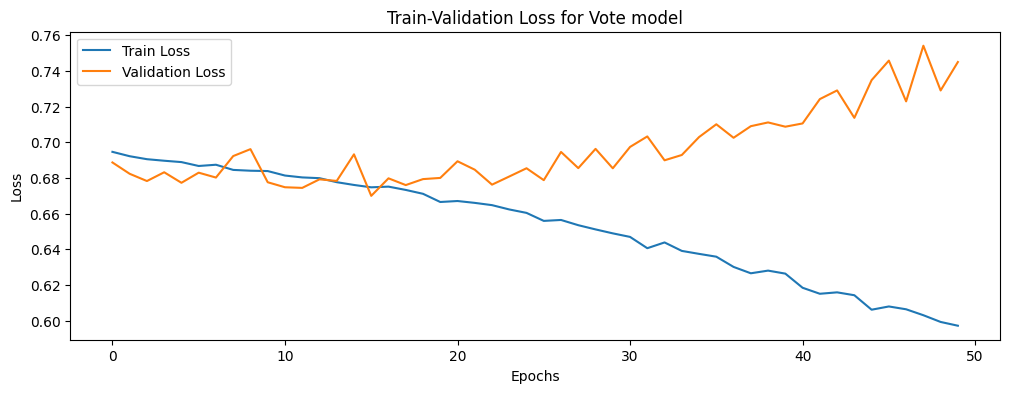

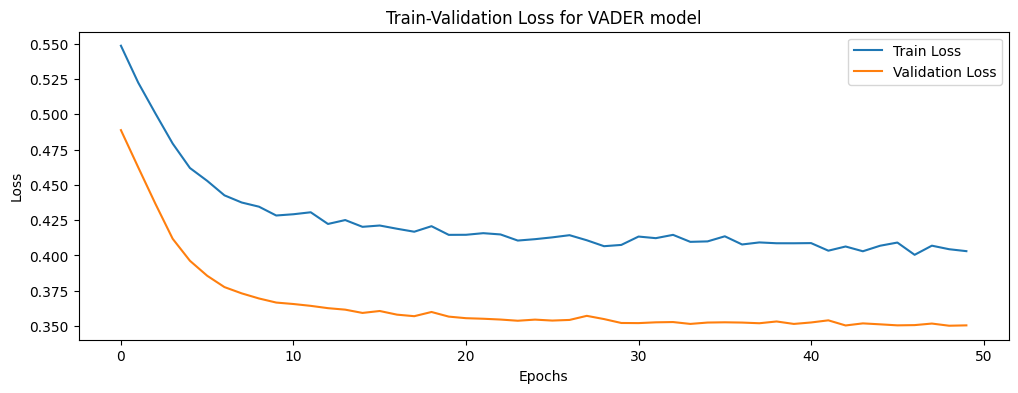

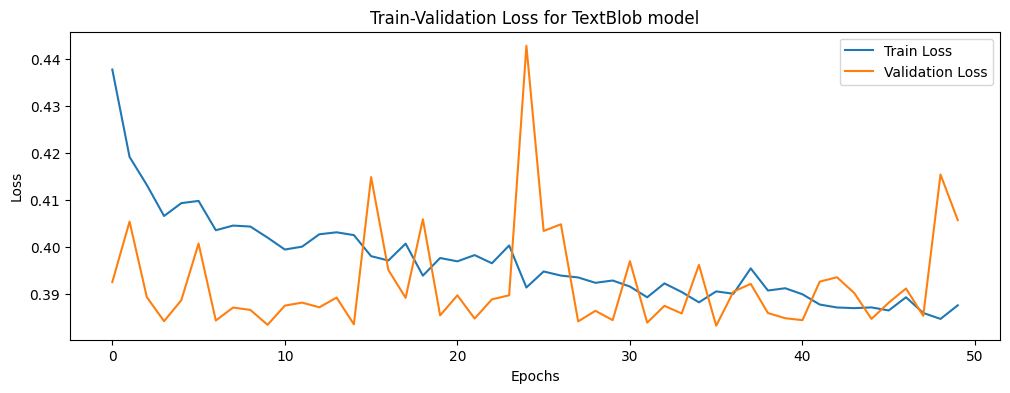

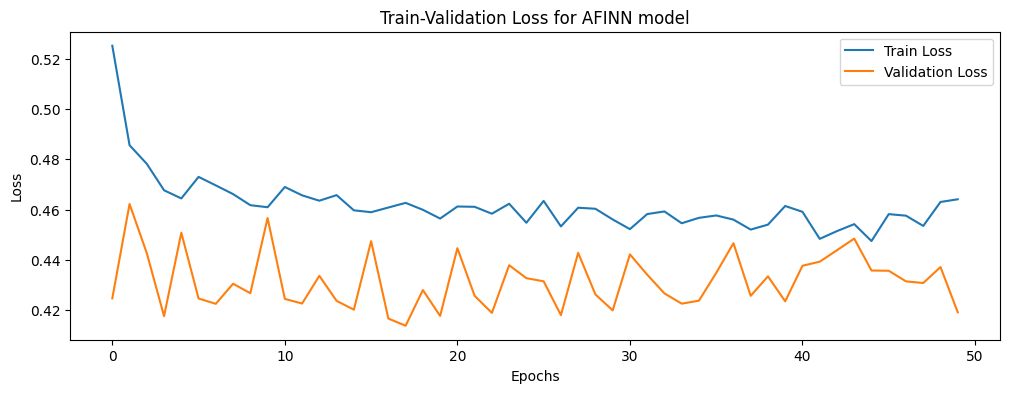

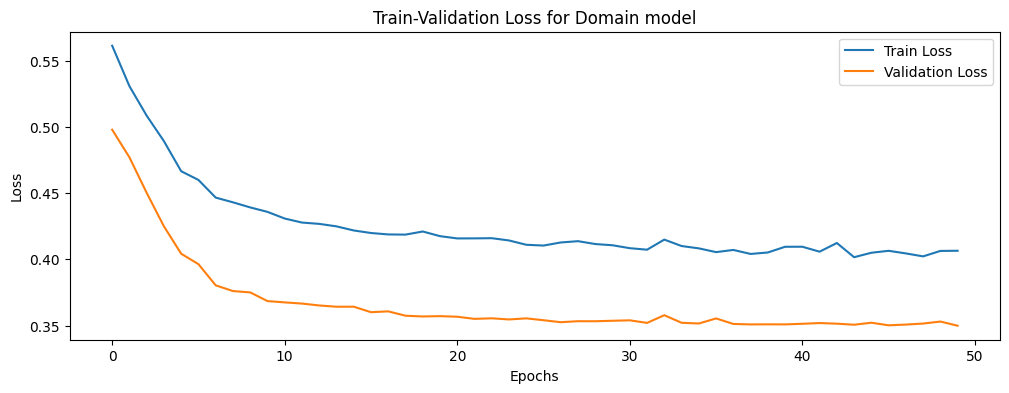

In [ ]:
# Plotting loss for vote
plt.figure(figsize=(12, 4))
plt.plot(history_vote.history['loss'], label='Train Loss')
plt.plot(history_vote.history['val_loss'], label='Validation Loss')
plt.title('Train-Validation Loss for Vote model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(history_vader.history['loss'], label='Train Loss')
plt.plot(history_vader.history['val_loss'], label='Validation Loss')
plt.title('Train-Validation Loss for VADER model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(history_vader_v2.history['loss'], label='Train Loss')
plt.plot(history_vader_v2.history['val_loss'], label='Validation Loss')
plt.title('Train-Validation Loss for VADER_v2 model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(history_textblob.history['loss'], label='Train Loss')
plt.plot(history_textblob.history['val_loss'], label='Validation Loss')
plt.title('Train-Validation Loss for TextBlob model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(history_textblob_v2.history['loss'], label='Train Loss')
plt.plot(history_textblob_v2.history['val_loss'], label='Validation Loss')
plt.title('Train-Validation Loss for TextBlob_v2 model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(history_afinn.history['loss'], label='Train Loss')
plt.plot(history_afinn.history['val_loss'], label='Validation Loss')
plt.title('Train-Validation Loss for AFINN model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(12, 4))
plt.plot(history_afinn_v2.history['loss'], label='Train Loss')
plt.plot(history_afinn_v2.history['val_loss'], label='Validation Loss')
plt.title('Train-Validation Loss for AFINN_v2 model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(history_domain.history['loss'], label='Train Loss')
plt.plot(history_domain.history['val_loss'], label='Validation Loss')
plt.title('Train-Validation Loss for Domain model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(history_domain_v2.history['loss'], label='Train Loss')
plt.plot(history_domain_v2.history['val_loss'], label='Validation Loss')
plt.title('Train-Validation Loss for Domain_v2 model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Making predictions

In [ ]:
X_test = pv_test['embeddings']

In [ ]:
# Convert data series to NumPy array
X_test = np.stack(X_test, axis=0)  # Convert the lists of embeddings to a NumPy array

In [ ]:
# DEFINE stats 
stats = []

# Define the filename for the CSV file
filename = 'hpo_experiment_results_diff_validation.csv'

# Define the header for the CSV file
header = ['Experiment', 'Model', 'Train label', 'Test label', 'Accuracy', 'Precision', 'Recall', 'F1', 'Majority baseline']

In [ ]:
#### INSTANTIATE FUNCTION SVM ####

def svm_pipeline(data, train_labels, test_labels, name, test_size=0.2):
    
    train_data, test_data, train_labels, _ = train_test_split(data, train_labels, test_size=test_size, stratify=vote_labels, random_state=42)
    test_labels = test_labels[len(train_labels):]
    splits = [(range(len(train_data)), range(len(test_data)))]
    
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    
    # It's a binary classification, LabelEncoder is used instead of LabelBinarizer
    train_labels = np.argmax(train_labels, axis=1)
    test_labels = np.argmax(test_labels, axis=1)
    le = LabelEncoder()
    train_labels = le.fit_transform(train_labels)
    test_labels = le.transform(test_labels)

    #data = data.values
    # Define the pipeline
     pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.9, min_df=5)),
    ('clf', LinearSVC(C=1.0, loss='squared_hinge', class_weight='balanced'))
    ])

    # Train the SVM classifier
    pipeline.fit(train_data, train_labels)

    y_pred = pipeline.predict(test_data)

    #EVALUATION METRICS
    accuracy = accuracy_score(test_labels, y_pred)
    precision = precision_score(test_labels, y_pred)
    recall = recall_score(test_labels, y_pred)
    f1 = f1_score(test_labels, y_pred)
    
    # Print the classification report
    print(classification_report(test_labels, y_pred))

    print(f"Accuracy: {accuracy:.2%}")
    print(f"Precision: {precision:.2%}")
    print(f"Recall: {recall:.2%}")
    print(f"F1-score: {f1:.2%}")

    return accuracy, precision, recall, f1

### Experiment 1: Vote - Vote

In [ ]:
import seaborn as sns

97/97 [==============================] - 1s 3ms/step


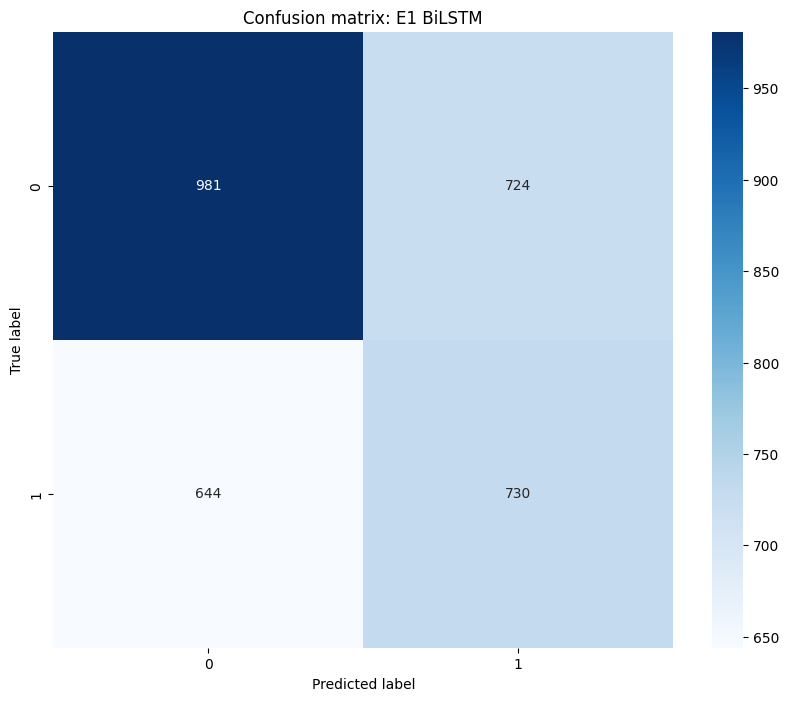

              precision    recall  f1-score   support

           0       0.60      0.58      0.59      1705
           1       0.50      0.53      0.52      1374

    accuracy                           0.56      3079
   macro avg       0.55      0.55      0.55      3079
weighted avg       0.56      0.56      0.56      3079



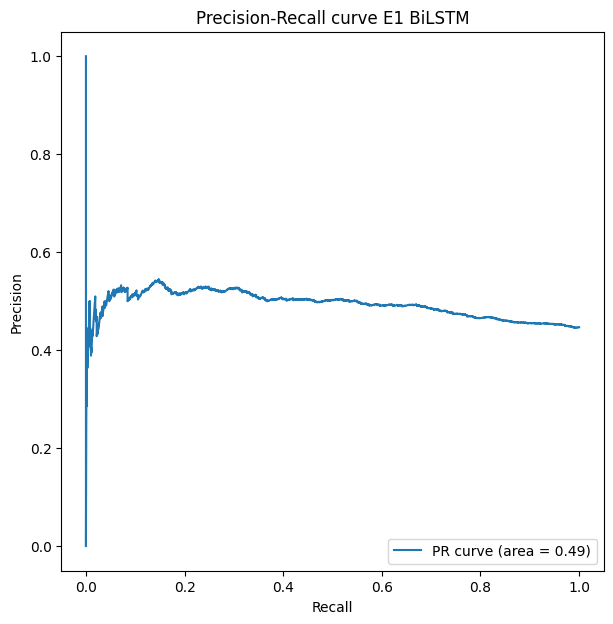

In [ ]:
###### BILSTM ######
# Load the saved model
model = load_model('best_model_vote.h5')

# Test labels, X_train = data is already defined
y_test = vote_labels_test

# Predict the classes
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E1 BiLSTM')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E1 BiLSTM')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 1 - BiLSTM to the results list (just one example)
stats.append(('1', 'BiLSTM', 'Vote', 'Vote', accuracy, precision, recall, f1, vote_majority))

In [1]:
####### train MLP #######
mlp_vote = Sequential([
    Dense(100, input_shape=(data.shape[1],)),  # Hidden layer of 100 nodes
    BatchNormalization(),  # Batch normalization
    Activation('relu'),  # ReLU activation function
    Dropout(0.5),  # Dropout regularization rate of 0.5
    Dense(vote_labels.shape[1], activation='sigmoid')  # Sigmoid activation in the output layer
])

mlp_vote.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
mlp_vote.fit(data, vote_labels, batch_size=32, epochs=10, verbose=1, validation_data=(x_val, vote_labels_val))


NameError: name 'Sequential' is not defined

97/97 [==============================] - 0s 2ms/step


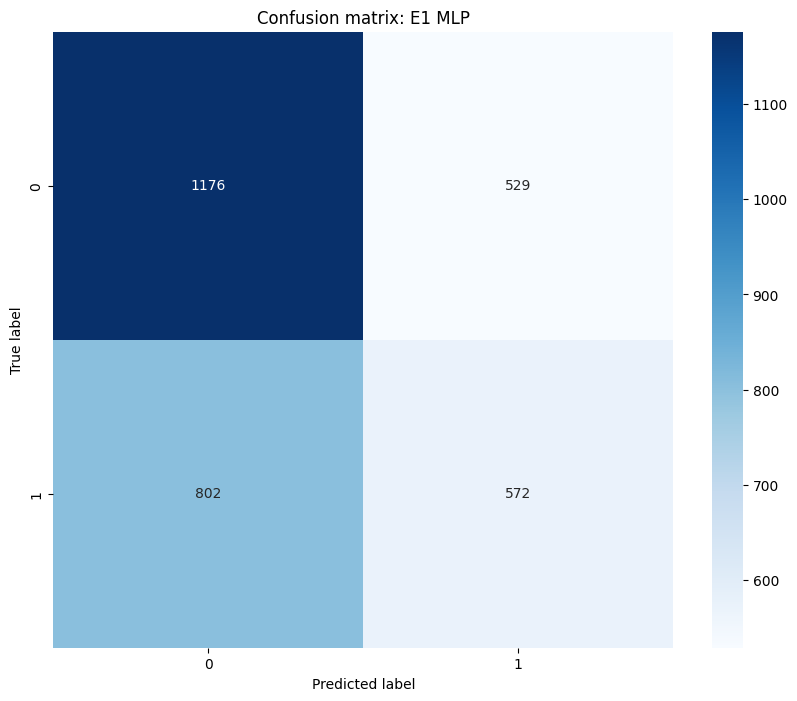

              precision    recall  f1-score   support

           0       0.59      0.69      0.64      1705
           1       0.52      0.42      0.46      1374

    accuracy                           0.57      3079
   macro avg       0.56      0.55      0.55      3079
weighted avg       0.56      0.57      0.56      3079



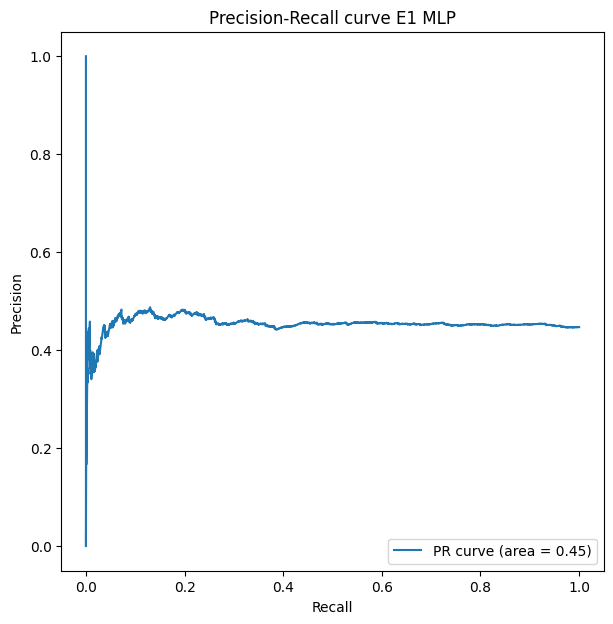

In [ ]:
##### EVALUATE MLP #####
# Test labels, X_train = data is already defined
y_test = vote_labels_test

# Predict the classes
y_pred = mlp_vote.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E1 MLP')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E1 MLP')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 1 - MLP to the results list (just one example)
stats.append(('1', 'MLP', 'Vote', 'Vote', accuracy, precision, recall, f1, vote_majority))

In [ ]:
#### SVM #####
accuracy, precision, recall, f1 = svm_pipeline(
    data=pv['speech_svm'],
    train_labels=vote_labels,
    test_labels=vote_labels,
    name='Experiment 1 SVM'
)

# Add the results to the results list
stats.append(('1', 'SVM', 'Vote', 'Vote', accuracy, precision, recall, f1, vote_majority))

              precision    recall  f1-score   support

           0       0.59      0.51      0.55      1425
           1       0.43      0.52      0.47      1039

    accuracy                           0.51      2464
   macro avg       0.51      0.51      0.51      2464
weighted avg       0.52      0.51      0.51      2464

Accuracy: 51.18%
Precision: 43.40%
Recall: 51.88%
F1-score: 47.26%


### Experiment 2: VADER - VADER

97/97 [==============================] - 1s 4ms/step


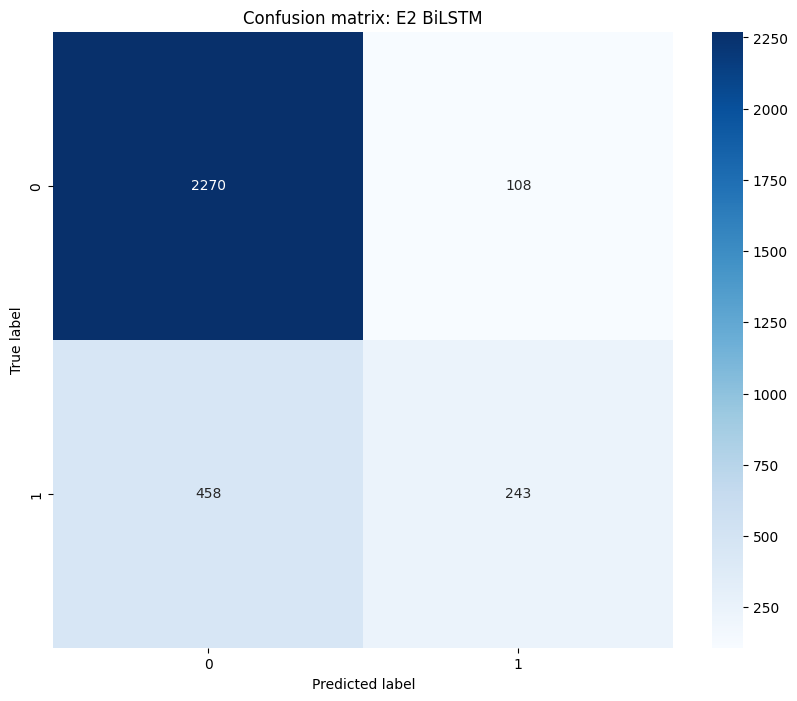

              precision    recall  f1-score   support

           0       0.83      0.95      0.89      2378
           1       0.69      0.35      0.46       701

    accuracy                           0.82      3079
   macro avg       0.76      0.65      0.68      3079
weighted avg       0.80      0.82      0.79      3079



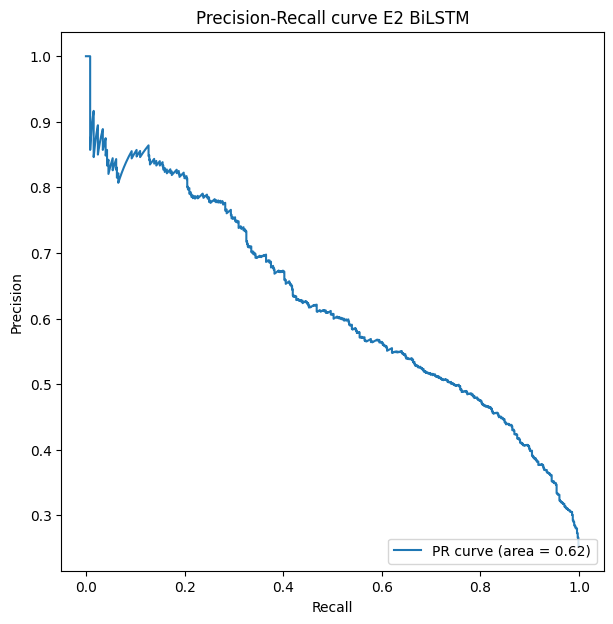

In [ ]:
###### BILSTM ######
# Load the saved model
model = load_model('best_model_vader.h5')

# Assume you have your test data in X_test and y_test
y_test = vader_labels_test

# Predict the classes
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E2 BiLSTM')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E2 BiLSTM')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 2 - BiLSTM to the results list (just one example)
stats.append(('2', 'BiLSTM', 'VADER', 'VADER', accuracy, precision, recall, f1, vader_majority))

Epoch 1/10
385/385 [==============================] - 2s 3ms/step - loss: 0.5106 - accuracy: 0.7672
Epoch 2/10
385/385 [==============================] - 1s 3ms/step - loss: 0.4021 - accuracy: 0.8156
Epoch 3/10
385/385 [==============================] - 1s 3ms/step - loss: 0.3808 - accuracy: 0.8267
Epoch 4/10
385/385 [==============================] - 1s 3ms/step - loss: 0.3670 - accuracy: 0.8336
Epoch 5/10
385/385 [==============================] - 1s 3ms/step - loss: 0.3600 - accuracy: 0.8391
Epoch 6/10
385/385 [==============================] - 1s 3ms/step - loss: 0.3495 - accuracy: 0.8425
Epoch 7/10
385/385 [==============================] - 1s 3ms/step - loss: 0.3422 - accuracy: 0.8491
Epoch 8/10
385/385 [==============================] - 1s 3ms/step - loss: 0.3365 - accuracy: 0.8498
Epoch 9/10
385/385 [==============================] - 1s 3ms/step - loss: 0.3245 - accuracy: 0.8569
Epoch 10/10
97/97 [==============================] - 0s 2ms/step


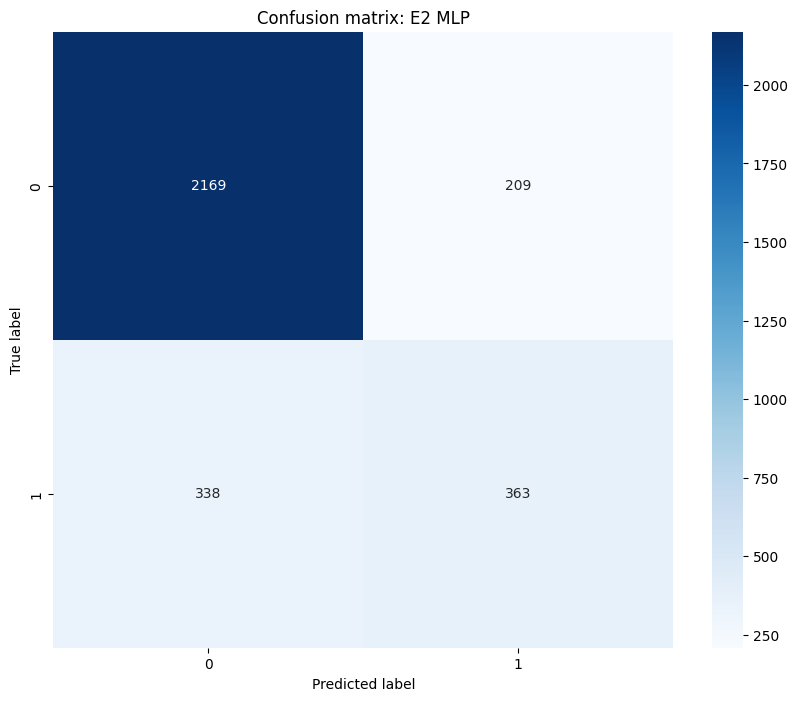

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      2378
           1       0.63      0.52      0.57       701

    accuracy                           0.82      3079
   macro avg       0.75      0.71      0.73      3079
weighted avg       0.81      0.82      0.82      3079



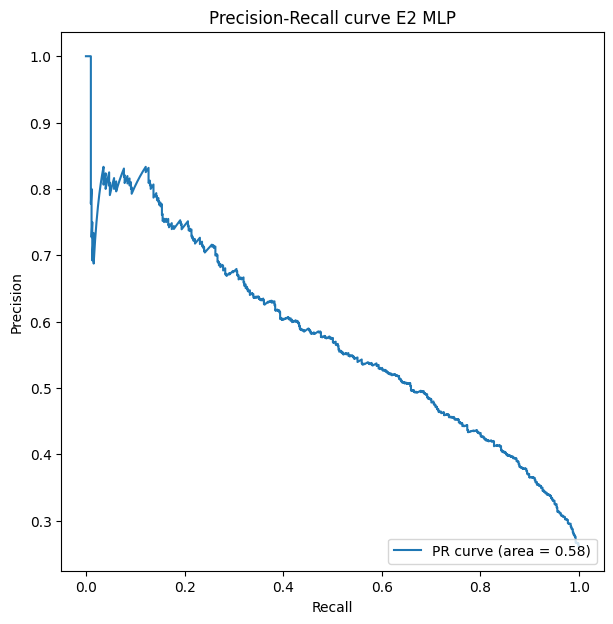

In [ ]:
####### train MLP #######
mlp_vader = Sequential([
    Dense(100, input_shape=(data.shape[1],)),  # Hidden layer of 100 nodes
    BatchNormalization(),  # Batch normalization
    Activation('relu'),  # ReLU activation function
    Dropout(0.5),  # Dropout regularization rate of 0.5
    Dense(vader_labels.shape[1], activation='sigmoid')  # Sigmoid activation in the output layer
])

mlp_vader.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
mlp_vader.fit(data, vader_labels, batch_size=32, epochs=10, verbose=1, validation_data=(x_val, vader_labels_val))


##### EVALUATE MLP #####
# Test labels, X_train = data is already defined
y_test = vader_labels_test

# Predict the classes
y_pred = mlp_vader.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E2 MLP')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E2 MLP')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 2 - MLP to the results list (just one example)
stats.append(('2', 'MLP', 'VADER', 'VADER', accuracy, precision, recall, f1, vader_majority))

In [ ]:
#### SVM #####
accuracy, precision, recall, f1 = svm_pipeline(
    data=pv['speech_svm'],
    train_labels=vader_labels,
    test_labels=vader_labels,
    name='Experiment 2 SVM'
)

# Add the results to the results list
stats.append(('2', 'SVM', 'VADER', 'VADER', accuracy, precision, recall, f1, vader_majority))

              precision    recall  f1-score   support

           0       0.79      0.72      0.76      1951
           1       0.21      0.29      0.25       513

    accuracy                           0.63      2464
   macro avg       0.50      0.51      0.50      2464
weighted avg       0.67      0.63      0.65      2464

Accuracy: 63.03%
Precision: 21.41%
Recall: 29.04%
F1-score: 24.65%


### Experiment 3: VADER - Vote

97/97 [==============================] - 1s 4ms/step


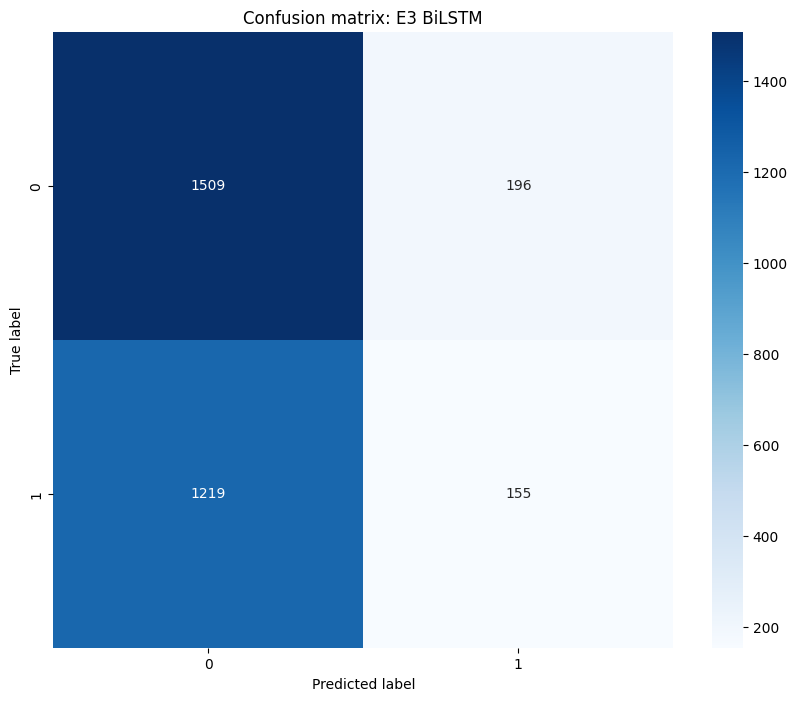

              precision    recall  f1-score   support

           0       0.55      0.89      0.68      1705
           1       0.44      0.11      0.18      1374

    accuracy                           0.54      3079
   macro avg       0.50      0.50      0.43      3079
weighted avg       0.50      0.54      0.46      3079



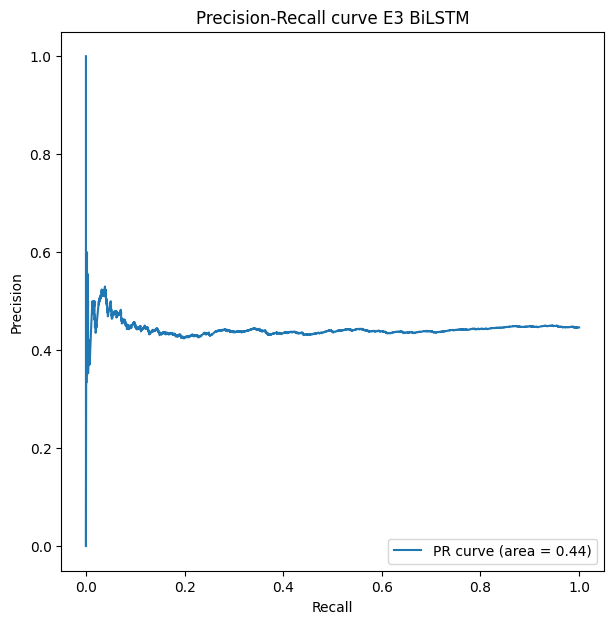

In [ ]:
###### BILSTM ######
# Load the saved model
model = load_model('best_model_vader_v2.h5')

# Assume you have your test data in X_test and y_test
y_test = vote_labels_test

# Predict the classes
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E3 BiLSTM')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E3 BiLSTM')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 3 - BiLSTM to the results list (just one example)
stats.append(('3', 'BiLSTM', 'VADER', 'Vote', accuracy, precision, recall, f1, vote_majority))

97/97 [==============================] - 0s 2ms/step


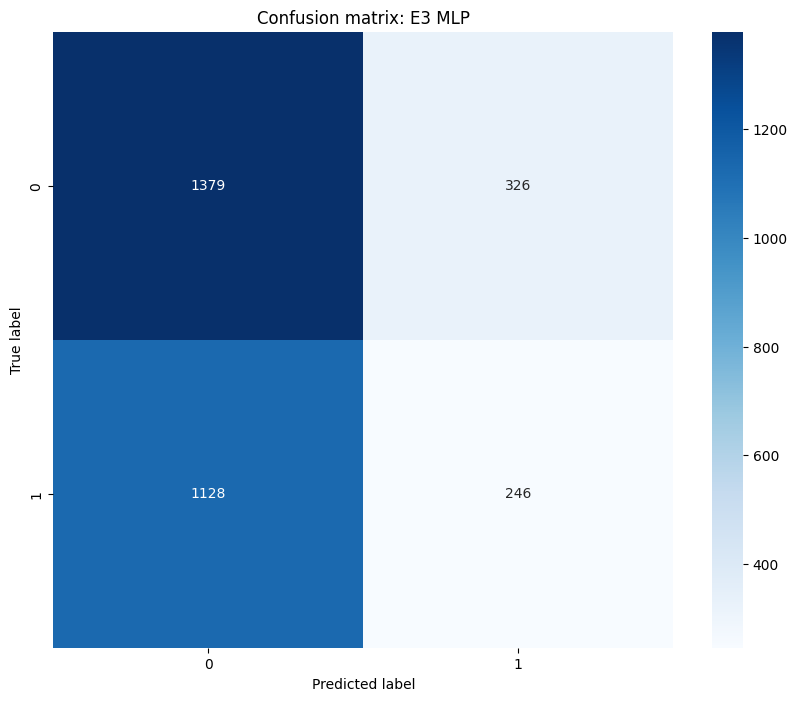

              precision    recall  f1-score   support

           0       0.55      0.81      0.65      1705
           1       0.43      0.18      0.25      1374

    accuracy                           0.53      3079
   macro avg       0.49      0.49      0.45      3079
weighted avg       0.50      0.53      0.48      3079



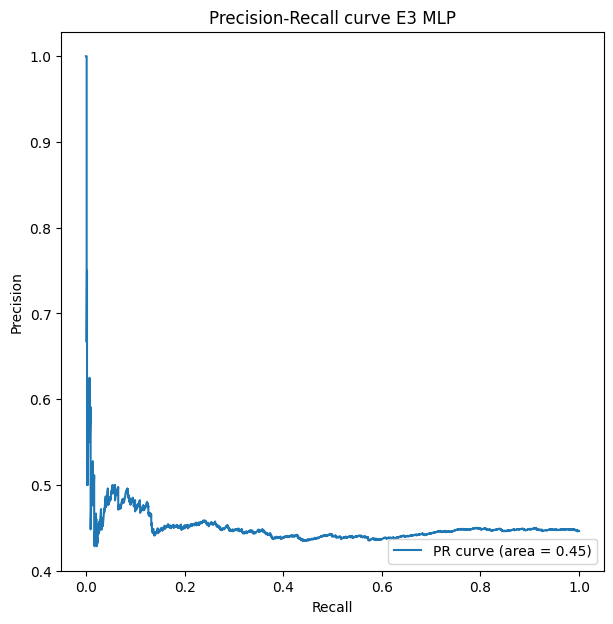

In [ ]:
##### EVALUATE MLP #####
####### train MLP #######
mlp_vader = Sequential([
    Dense(100, input_shape=(data.shape[1],)),  # Hidden layer of 100 nodes
    BatchNormalization(),  # Batch normalization
    Activation('relu'),  # ReLU activation function
    Dropout(0.5),  # Dropout regularization rate of 0.5
    Dense(vader_labels.shape[1], activation='sigmoid')  # Sigmoid activation in the output layer
])

mlp_vader.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
mlp_vader.fit(data, vader_labels, batch_size=32, epochs=10, verbose=1, validation_data=(x_val, vote_labels_val))

# Test labels, X_train = data is already defined
y_test = vote_labels_test

# Predict the classes
y_pred = mlp_vader.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E3 MLP')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E3 MLP')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 3 - BiLSTM to the results list (just one example)
stats.append(('3', 'MLP', 'VADER', 'Vote', accuracy, precision, recall, f1, vote_majority))

In [ ]:
#### SVM #####
accuracy, precision, recall, f1 = svm_pipeline(
    data=pv['speech_svm'],
    train_labels=vader_labels,
    test_labels=vote_labels,
    name='Experiment 3 SVM'
)

# Add the results to the results list
stats.append(('3', 'SVM', 'VADER', 'Vote', accuracy, precision, recall, f1, vote_majority))

              precision    recall  f1-score   support

           0       0.58      0.72      0.64      1425
           1       0.43      0.29      0.34      1039

    accuracy                           0.54      2464
   macro avg       0.51      0.50      0.49      2464
weighted avg       0.52      0.54      0.52      2464

Accuracy: 53.86%
Precision: 42.96%
Recall: 28.78%
F1-score: 34.47%


### Experiment 4: TextBlob - TextBlob

97/97 [==============================] - 1s 3ms/step


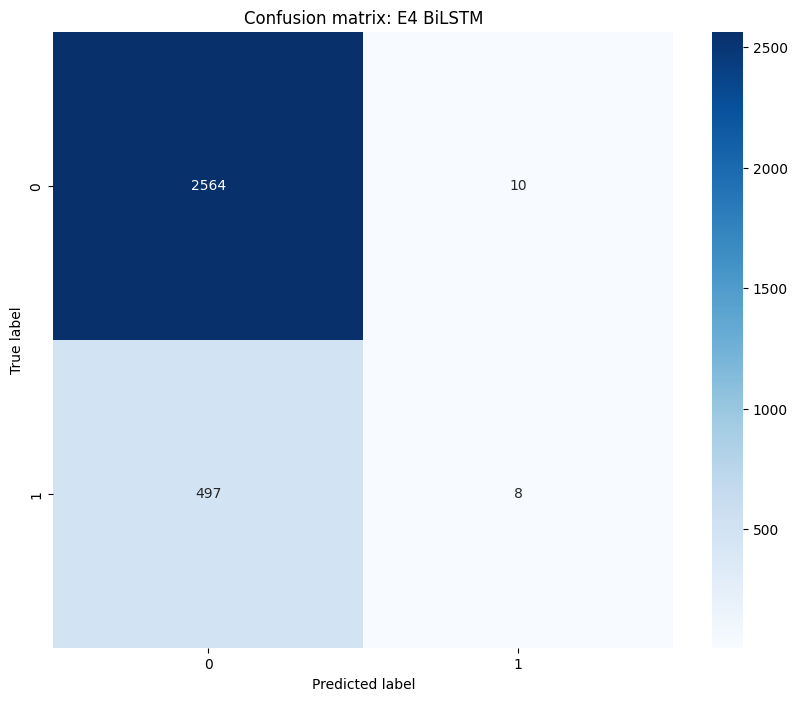

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      2574
           1       0.44      0.02      0.03       505

    accuracy                           0.84      3079
   macro avg       0.64      0.51      0.47      3079
weighted avg       0.77      0.84      0.77      3079



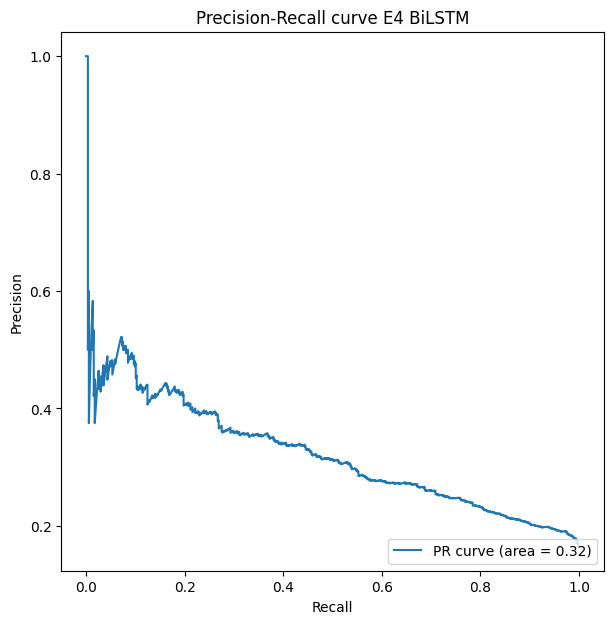

In [ ]:
###### BILSTM ######
# Load the saved model
model = load_model('best_model_textblob.h5')

# Assume you have your test data in X_test and y_test
y_test = textblob_labels_test

# Predict the classes
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E4 BiLSTM')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E4 BiLSTM')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 3 - BiLSTM to the results list (just one example)
stats.append(('4', 'BiLSTM', 'TextBlob', 'TextBlob', accuracy, precision, recall, f1, textblob_majority))

Epoch 1/10
385/385 [==============================] - 2s 3ms/step - loss: 0.4852 - accuracy: 0.7994
Epoch 2/10
385/385 [==============================] - 1s 3ms/step - loss: 0.4006 - accuracy: 0.8410
Epoch 3/10
385/385 [==============================] - 1s 3ms/step - loss: 0.3777 - accuracy: 0.8453
Epoch 4/10
385/385 [==============================] - 1s 3ms/step - loss: 0.3691 - accuracy: 0.8466
Epoch 5/10
385/385 [==============================] - 1s 3ms/step - loss: 0.3627 - accuracy: 0.8483
Epoch 6/10
385/385 [==============================] - 1s 3ms/step - loss: 0.3530 - accuracy: 0.8504
Epoch 7/10
385/385 [==============================] - 1s 3ms/step - loss: 0.3446 - accuracy: 0.8530
Epoch 8/10
385/385 [==============================] - 1s 3ms/step - loss: 0.3408 - accuracy: 0.8591
Epoch 9/10
385/385 [==============================] - 1s 3ms/step - loss: 0.3342 - accuracy: 0.8587
Epoch 10/10
97/97 [==============================] - 0s 1ms/step


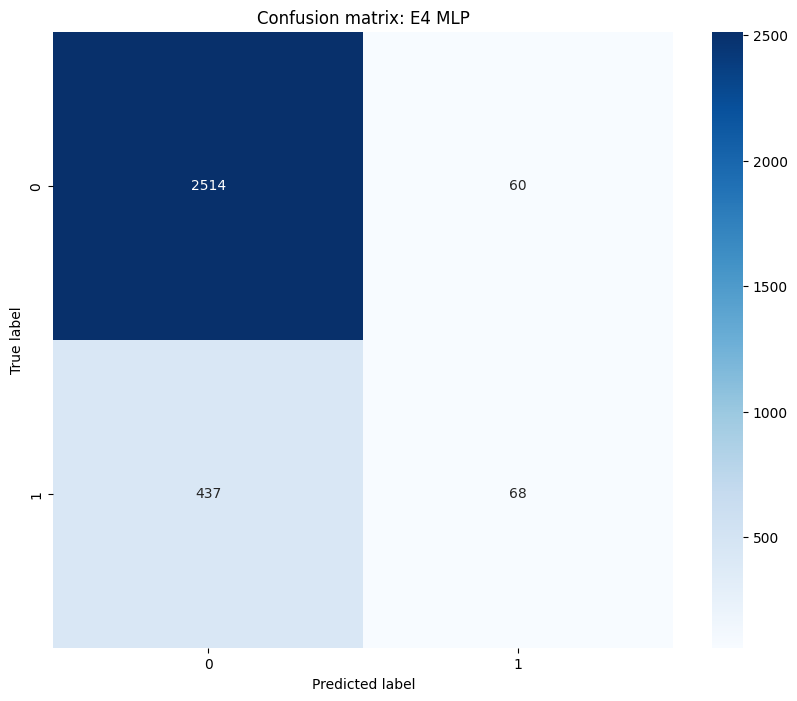

              precision    recall  f1-score   support

           0       0.85      0.98      0.91      2574
           1       0.53      0.13      0.21       505

    accuracy                           0.84      3079
   macro avg       0.69      0.56      0.56      3079
weighted avg       0.80      0.84      0.80      3079



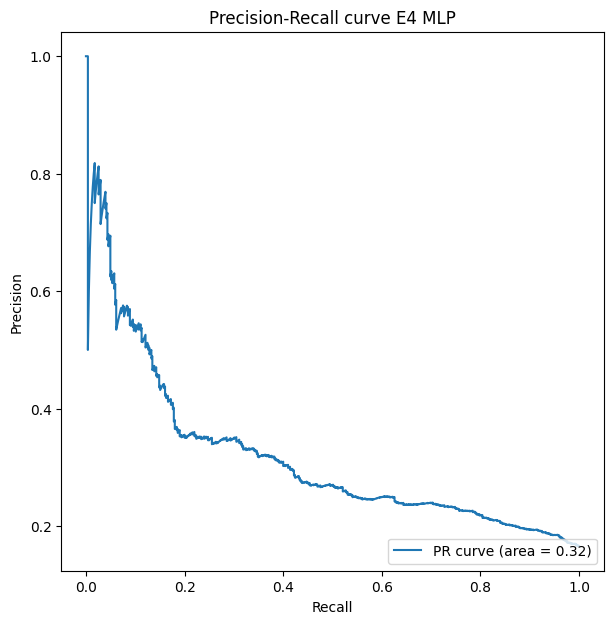

In [ ]:
####### train MLP #######
mlp_textblob = Sequential([
    Dense(100, input_shape=(data.shape[1],)),  # Hidden layer of 100 nodes
    BatchNormalization(),  # Batch normalization
    Activation('relu'),  # ReLU activation function
    Dropout(0.5),  # Dropout regularization rate of 0.5
    Dense(textblob_labels.shape[1], activation='sigmoid')  # Sigmoid activation in the output layer
])

mlp_textblob.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
mlp_textblob.fit(data, textblob_labels, batch_size=32, epochs=10, verbose=1, validation_data=(x_val, textblob_labels_val))


##### EVALUATE MLP #####
# Test labels, X_train = data is already defined
y_test = textblob_labels_test

# Predict the classes
y_pred = mlp_textblob.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E4 MLP')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E4 MLP')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 3 - BiLSTM to the results list (just one example)
stats.append(('4', 'MLP', 'TextBlob', 'TextBlob', accuracy, precision, recall, f1, textblob_majority))

In [ ]:
#### SVM #####
accuracy, precision, recall, f1 = svm_pipeline(
    data=pv['speech_svm'],
    train_labels=textblob_labels,
    test_labels=textblob_labels,
    name='Experiment 4 SVM'
)

# Add the results to the results list
stats.append(('4', 'SVM', 'TextBlob', 'TextBlob', accuracy, precision, recall, f1, textblob_majority))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82      2086
           1       0.17      0.23      0.20       378

    accuracy                           0.71      2464
   macro avg       0.51      0.51      0.51      2464
weighted avg       0.75      0.71      0.72      2464

Accuracy: 70.54%
Precision: 16.79%
Recall: 23.28%
F1-score: 19.51%


### Experiment 5: TextBlob - Vote

97/97 [==============================] - 1s 4ms/step


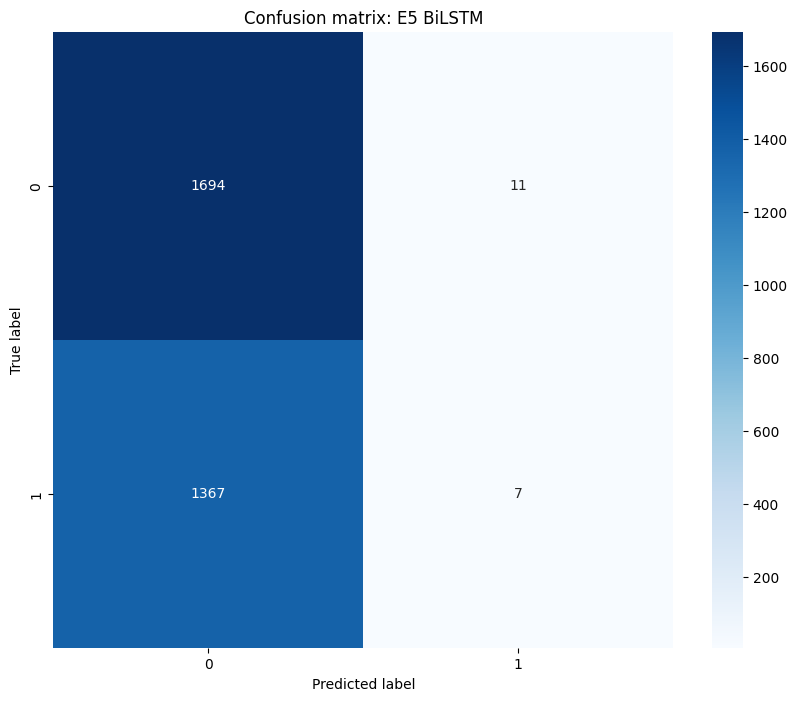

              precision    recall  f1-score   support

           0       0.55      0.99      0.71      1705
           1       0.39      0.01      0.01      1374

    accuracy                           0.55      3079
   macro avg       0.47      0.50      0.36      3079
weighted avg       0.48      0.55      0.40      3079



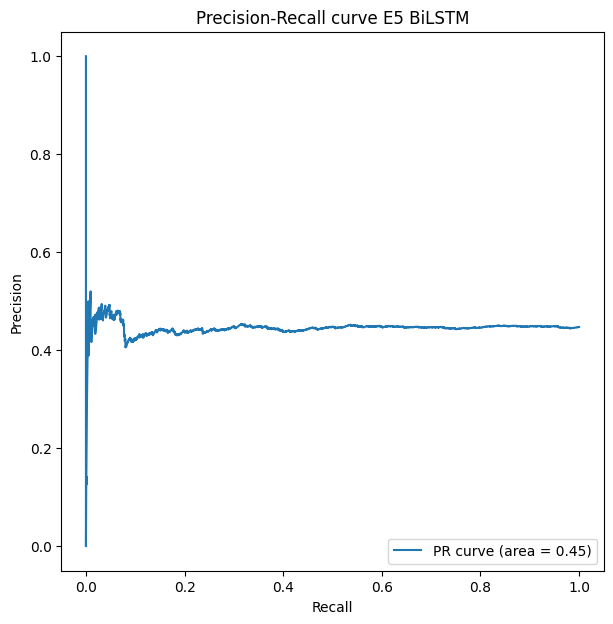

In [ ]:
###### BILSTM ######
# Load the saved model
model = load_model('best_model_textblob_v2.h5')

# Assume you have your test data in X_test and y_test
y_test = vote_labels_test

# Predict the classes
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E5 BiLSTM')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E5 BiLSTM')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 3 - BiLSTM to the results list (just one example)
stats.append(('5', 'BiLSTM', 'TextBlob', 'Vote', accuracy, precision, recall, f1, vote_majority))

97/97 [==============================] - 0s 2ms/step


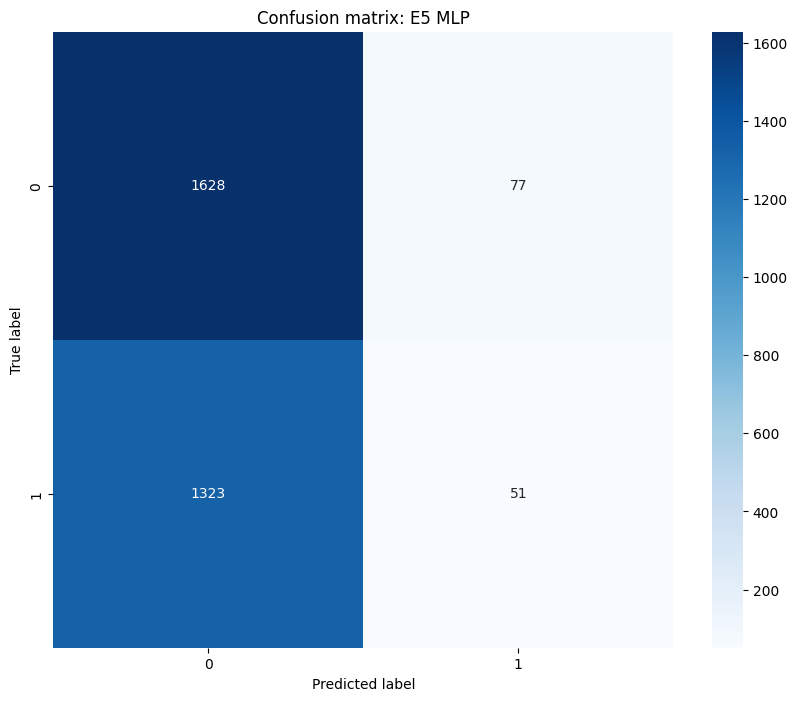

              precision    recall  f1-score   support

           0       0.55      0.95      0.70      1705
           1       0.40      0.04      0.07      1374

    accuracy                           0.55      3079
   macro avg       0.48      0.50      0.38      3079
weighted avg       0.48      0.55      0.42      3079



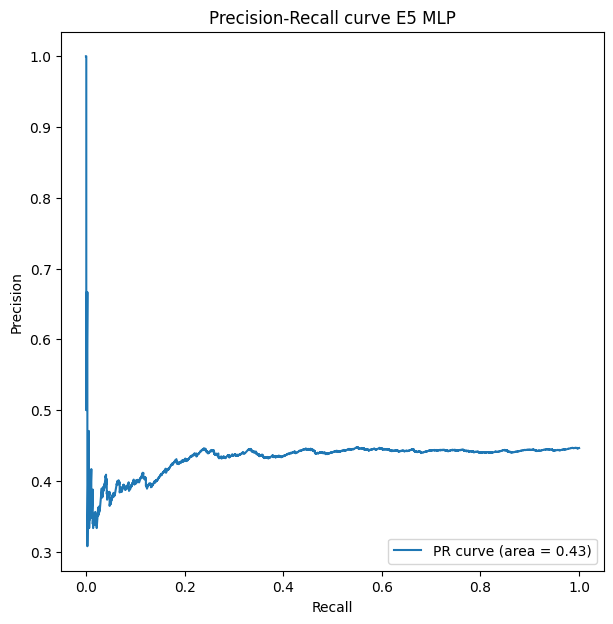

In [ ]:
##### EVALUATE MLP #####
mlp_textblob = Sequential([
    Dense(100, input_shape=(data.shape[1],)),  # Hidden layer of 100 nodes
    BatchNormalization(),  # Batch normalization
    Activation('relu'),  # ReLU activation function
    Dropout(0.5),  # Dropout regularization rate of 0.5
    Dense(textblob_labels.shape[1], activation='sigmoid')  # Sigmoid activation in the output layer
])

mlp_textblob.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
mlp_textblob.fit(data, textblob_labels, batch_size=32, epochs=10, verbose=1, validation_data=(x_val, vote_labels_val))


# Test labels, X_train = data is already defined
y_test = vote_labels_test

# Predict the classes
y_pred = mlp_textblob.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E5 MLP')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E5 MLP')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 3 - BiLSTM to the results list (just one example)
stats.append(('5', 'MLP', 'TextBlob', 'Vote', accuracy, precision, recall, f1, vote_majority))

In [ ]:
#### SVM #####
accuracy, precision, recall, f1 = svm_pipeline(
    data=pv['speech_svm'],
    train_labels=textblob_labels,
    test_labels=vote_labels,
    name='Experiment 5 SVM'
)

# Add the results to the results list
stats.append(('5', 'SVM', 'TextBlob', 'Vote', accuracy, precision, recall, f1, vote_majority))

              precision    recall  f1-score   support

           0       0.57      0.78      0.66      1425
           1       0.41      0.21      0.27      1039

    accuracy                           0.54      2464
   macro avg       0.49      0.49      0.47      2464
weighted avg       0.50      0.54      0.50      2464

Accuracy: 53.86%
Precision: 40.65%
Recall: 20.50%
F1-score: 27.26%


### Experiment 6

97/97 [==============================] - 1s 3ms/step


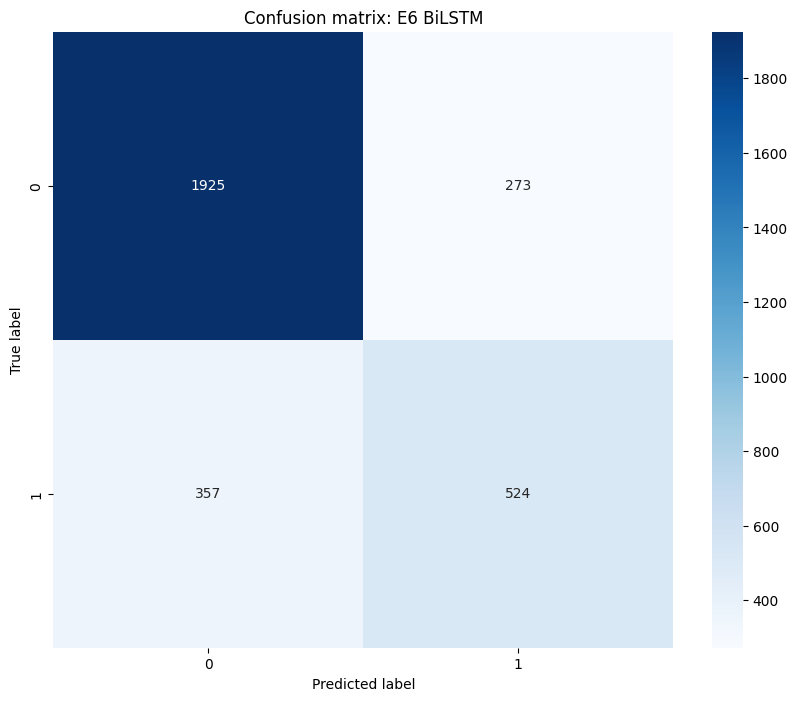

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      2198
           1       0.66      0.59      0.62       881

    accuracy                           0.80      3079
   macro avg       0.75      0.74      0.74      3079
weighted avg       0.79      0.80      0.79      3079



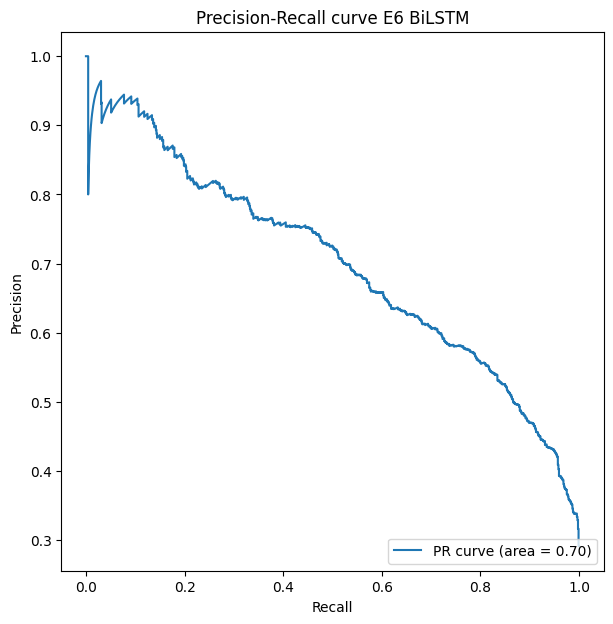

In [ ]:
###### BILSTM ######
# Load the saved model
model = load_model('best_model_afinn.h5')

# Assume you have your test data in X_test and y_test
y_test = afinn_labels_test

# Predict the classes
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E6 BiLSTM')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E6 BiLSTM')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 3 - BiLSTM to the results list (just one example)
stats.append(('6', 'BiLSTM', 'AFINN', 'AFINN', accuracy, precision, recall, f1, afinn_majority))

Epoch 1/10
385/385 [==============================] - 2s 3ms/step - loss: 0.5416 - accuracy: 0.7495
Epoch 2/10
385/385 [==============================] - 1s 3ms/step - loss: 0.4301 - accuracy: 0.7939
Epoch 3/10
385/385 [==============================] - 1s 3ms/step - loss: 0.4005 - accuracy: 0.8113
Epoch 4/10
385/385 [==============================] - 1s 3ms/step - loss: 0.3895 - accuracy: 0.8198
Epoch 5/10
385/385 [==============================] - 1s 3ms/step - loss: 0.3799 - accuracy: 0.8262
Epoch 6/10
385/385 [==============================] - 1s 3ms/step - loss: 0.3685 - accuracy: 0.8306
Epoch 7/10
385/385 [==============================] - 1s 3ms/step - loss: 0.3622 - accuracy: 0.8372
Epoch 8/10
385/385 [==============================] - 1s 3ms/step - loss: 0.3506 - accuracy: 0.8390
Epoch 9/10
385/385 [==============================] - 1s 3ms/step - loss: 0.3503 - accuracy: 0.8448
Epoch 10/10
97/97 [==============================] - 0s 2ms/step


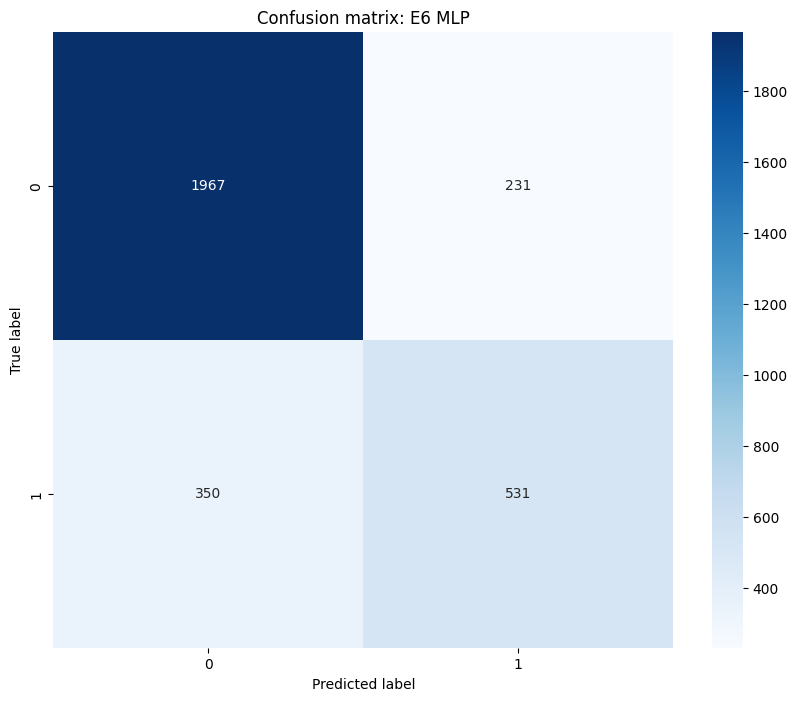

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      2198
           1       0.70      0.60      0.65       881

    accuracy                           0.81      3079
   macro avg       0.77      0.75      0.76      3079
weighted avg       0.81      0.81      0.81      3079



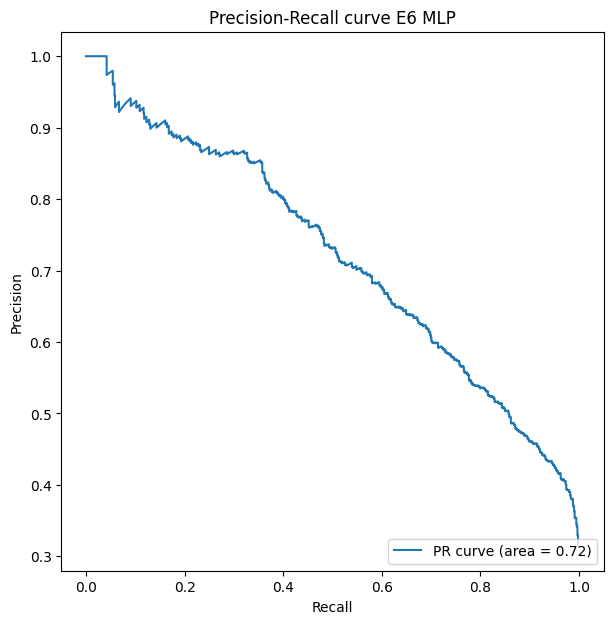

In [ ]:
####### train MLP #######
mlp_afinn = Sequential([
    Dense(100, input_shape=(data.shape[1],)),  # Hidden layer of 100 nodes
    BatchNormalization(),  # Batch normalization
    Activation('relu'),  # ReLU activation function
    Dropout(0.5),  # Dropout regularization rate of 0.5
    Dense(afinn_labels.shape[1], activation='sigmoid')  # Sigmoid activation in the output layer
])

mlp_afinn.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
mlp_afinn.fit(data, afinn_labels, batch_size=32, epochs=10, verbose=1, validation_data=(x_val, afinn_labels_val))


##### EVALUATE MLP #####
# Test labels, X_train = data is already defined
y_test = afinn_labels_test

# Predict the classes
y_pred = mlp_afinn.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E6 MLP')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E6 MLP')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 3 - BiLSTM to the results list (just one example)
stats.append(('6', 'MLP', 'AFINN', 'AFINN', accuracy, precision, recall, f1, afinn_majority))

In [ ]:
#### SVM #####
accuracy, precision, recall, f1 = svm_pipeline(
    data=pv['speech_svm'],
    train_labels=afinn_labels,
    test_labels=afinn_labels,
    name='Experiment 6 SVM'
)

# Add the results to the results list
stats.append(('6', 'SVM', 'AFINN', 'AFINN', accuracy, precision, recall, f1, afinn_majority))

              precision    recall  f1-score   support

           0       0.73      0.69      0.71      1787
           1       0.29      0.33      0.31       677

    accuracy                           0.59      2464
   macro avg       0.51      0.51      0.51      2464
weighted avg       0.61      0.59      0.60      2464

Accuracy: 59.42%
Precision: 29.05%
Recall: 33.09%
F1-score: 30.94%


### Experiment 7: AFINN - Vote

97/97 [==============================] - 1s 4ms/step


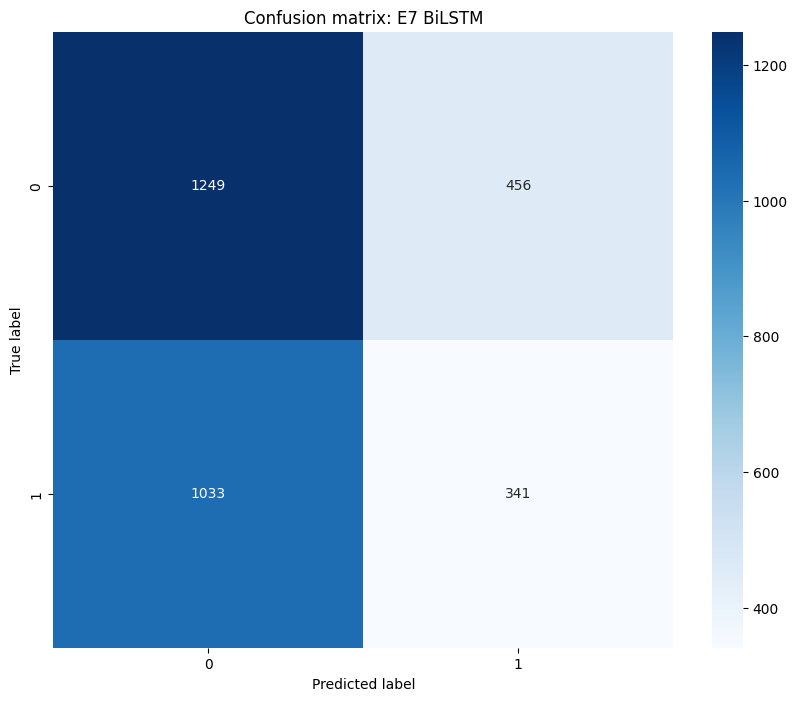

              precision    recall  f1-score   support

           0       0.55      0.73      0.63      1705
           1       0.43      0.25      0.31      1374

    accuracy                           0.52      3079
   macro avg       0.49      0.49      0.47      3079
weighted avg       0.49      0.52      0.49      3079



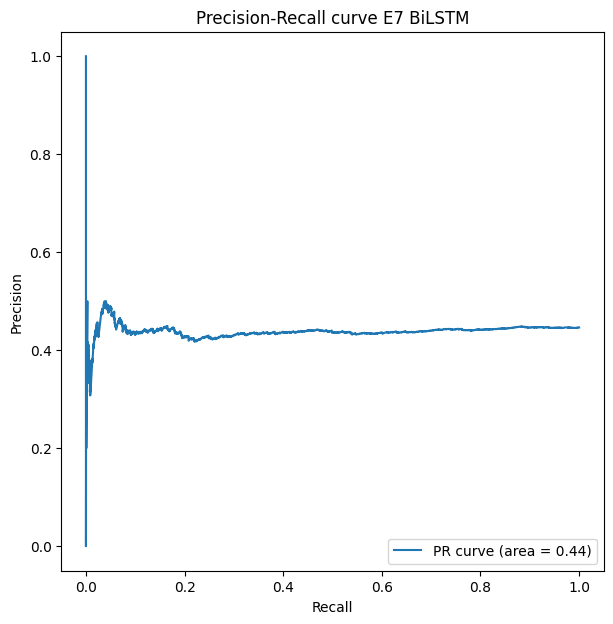

In [ ]:
###### BILSTM ######
# Load the saved model
model = load_model('best_model_afinn_v2.h5')

# Assume you have your test data in X_test and y_test
y_test = vote_labels_test

# Predict the classes
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E7 BiLSTM')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E7 BiLSTM')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 7 - BiLSTM to the results list (just one example)
stats.append(('7', 'BiLSTM', 'AFINN', 'Vote', accuracy, precision, recall, f1, vote_majority))

97/97 [==============================] - 0s 2ms/step


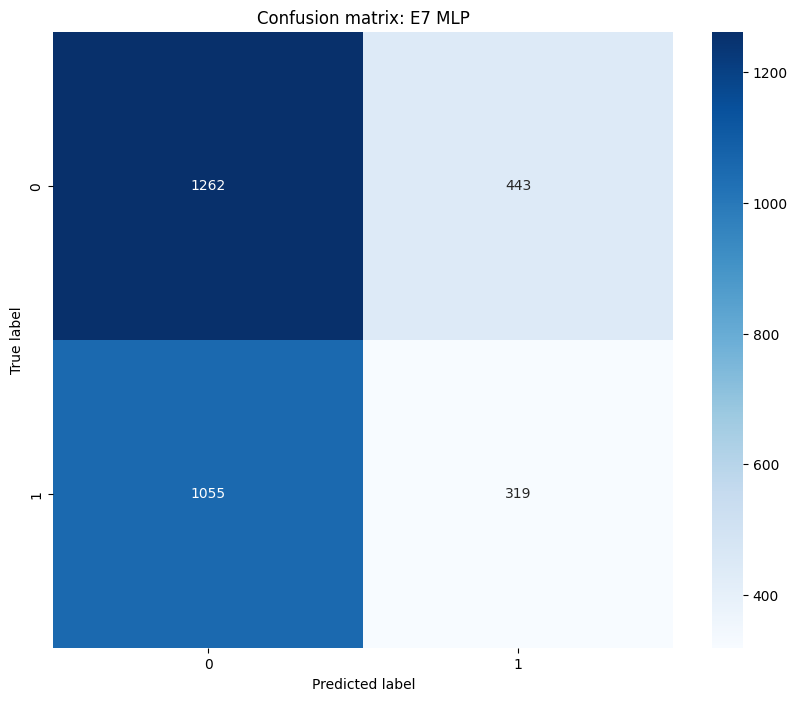

              precision    recall  f1-score   support

           0       0.54      0.74      0.63      1705
           1       0.42      0.23      0.30      1374

    accuracy                           0.51      3079
   macro avg       0.48      0.49      0.46      3079
weighted avg       0.49      0.51      0.48      3079



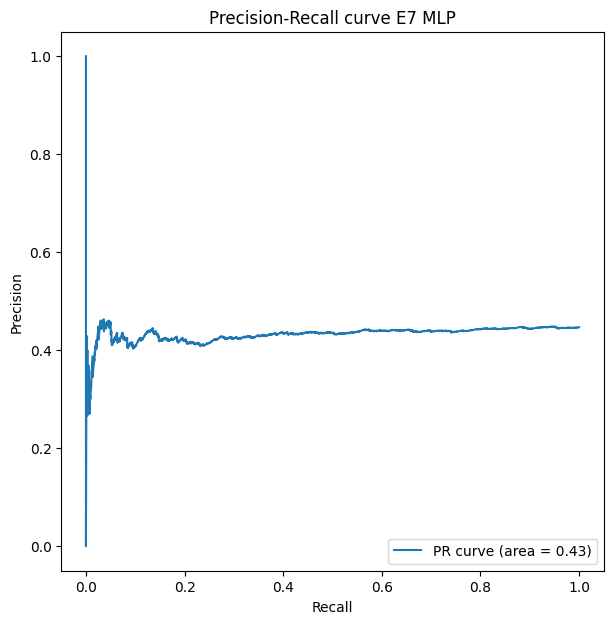

In [ ]:
##### EVALUATE MLP #####
mlp_afinn = Sequential([
    Dense(100, input_shape=(data.shape[1],)),  # Hidden layer of 100 nodes
    BatchNormalization(),  # Batch normalization
    Activation('relu'),  # ReLU activation function
    Dropout(0.5),  # Dropout regularization rate of 0.5
    Dense(afinn_labels.shape[1], activation='sigmoid')  # Sigmoid activation in the output layer
])

mlp_afinn.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
mlp_afinn.fit(data, afinn_labels, batch_size=32, epochs=10, verbose=1, validation_data=(x_val, vote_labels_val))

# Test labels, X_train = data is already defined
y_test = vote_labels_test

# Predict the classes
y_pred = mlp_afinn.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E7 MLP')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E7 MLP')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 7 - MLP to the results list (just one example)
stats.append(('7', 'MLP', 'AFINN', 'Vote', accuracy, precision, recall, f1, vote_majority))

In [ ]:
#### SVM #####
accuracy, precision, recall, f1 = svm_pipeline(
    data=pv['speech_svm'],
    train_labels=afinn_labels,
    test_labels=vote_labels,
    name='Experiment 7 SVM'
)

# Add the results to the results list
stats.append(('7', 'SVM', 'AFINN', 'Vote', accuracy, precision, recall, f1, vote_majority))

              precision    recall  f1-score   support

           0       0.58      0.68      0.63      1425
           1       0.42      0.31      0.36      1039

    accuracy                           0.53      2464
   macro avg       0.50      0.50      0.49      2464
weighted avg       0.51      0.53      0.51      2464

Accuracy: 52.68%
Precision: 41.76%
Recall: 30.99%
F1-score: 35.58%


## Experiment 8

97/97 [==============================] - 1s 5ms/step


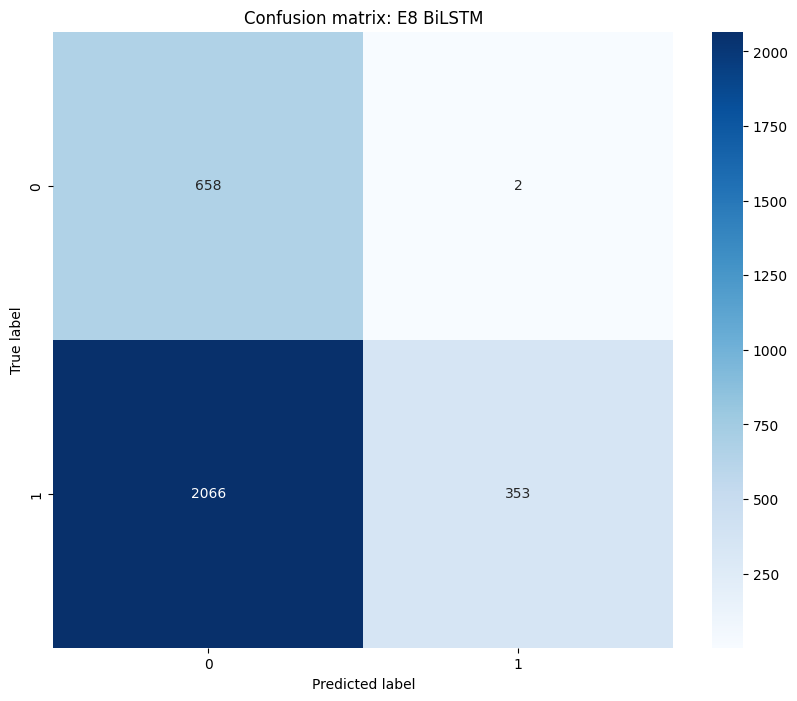

              precision    recall  f1-score   support

           0       0.24      1.00      0.39       660
           1       0.99      0.15      0.25      2419

    accuracy                           0.33      3079
   macro avg       0.62      0.57      0.32      3079
weighted avg       0.83      0.33      0.28      3079



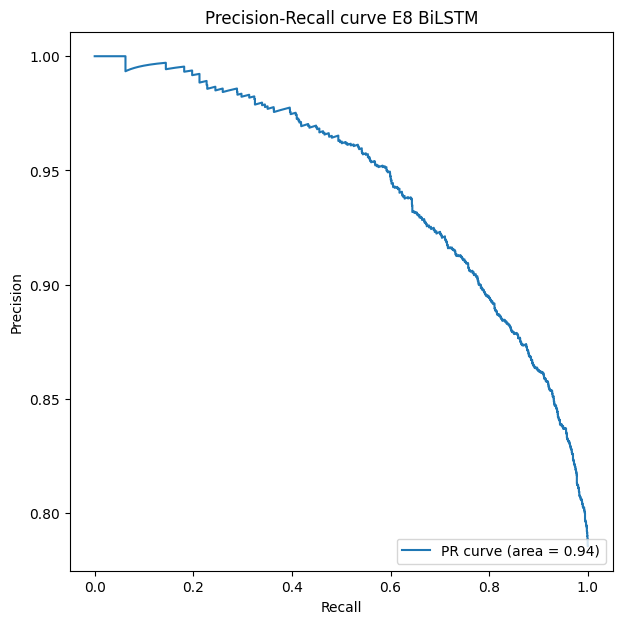

In [ ]:
###### BILSTM ######
# Load the saved model
model = load_model('best_model_domain.h5')

# Assume you have your test data in X_test and y_test
y_test = domain_labels_test

# Predict the classes
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E8 BiLSTM')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E8 BiLSTM')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 8 - Domain to the results list (just one example)
stats.append(('8', 'BiLSTM', 'Domain', 'Domain', accuracy, precision, recall, f1, domain_majority))

Epoch 1/10
385/385 [==============================] - 2s 3ms/step - loss: 0.4008 - accuracy: 0.8149
Epoch 2/10
385/385 [==============================] - 1s 3ms/step - loss: 0.3122 - accuracy: 0.8618
Epoch 3/10
385/385 [==============================] - 1s 3ms/step - loss: 0.2949 - accuracy: 0.8686
Epoch 4/10
385/385 [==============================] - 1s 3ms/step - loss: 0.2836 - accuracy: 0.8739
Epoch 5/10
385/385 [==============================] - 1s 3ms/step - loss: 0.2726 - accuracy: 0.8793
Epoch 6/10
385/385 [==============================] - 1s 3ms/step - loss: 0.2694 - accuracy: 0.8794
Epoch 7/10
385/385 [==============================] - 1s 3ms/step - loss: 0.2644 - accuracy: 0.8837
Epoch 8/10
385/385 [==============================] - 1s 3ms/step - loss: 0.2587 - accuracy: 0.8854
Epoch 9/10
385/385 [==============================] - 1s 3ms/step - loss: 0.2502 - accuracy: 0.8900
Epoch 10/10
97/97 [==============================] - 0s 2ms/step


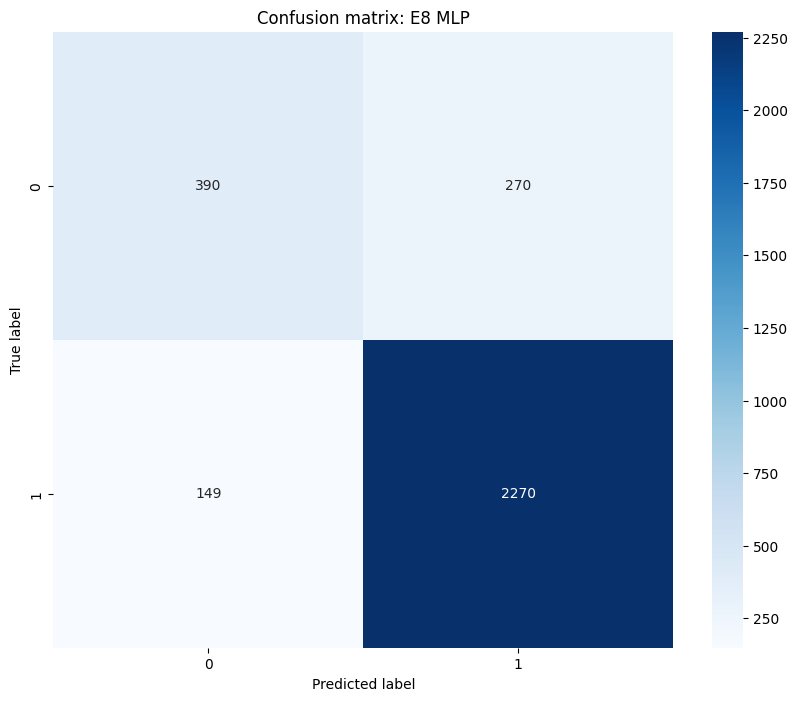

              precision    recall  f1-score   support

           0       0.72      0.59      0.65       660
           1       0.89      0.94      0.92      2419

    accuracy                           0.86      3079
   macro avg       0.81      0.76      0.78      3079
weighted avg       0.86      0.86      0.86      3079



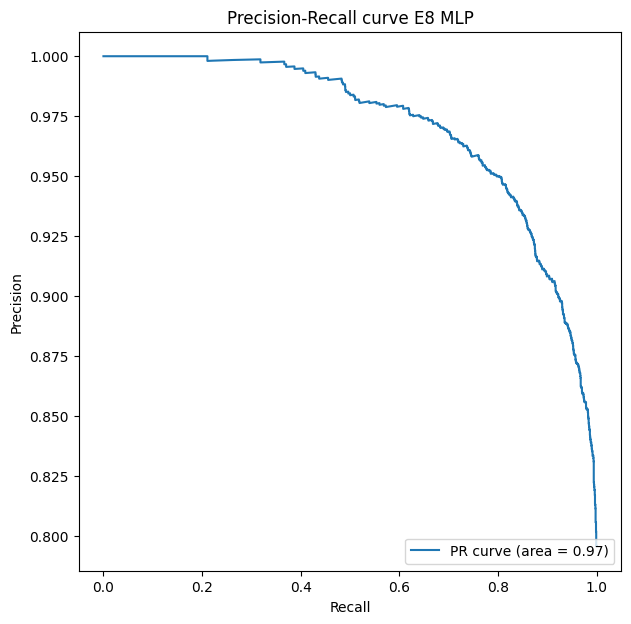

In [ ]:
####### train MLP #######
mlp_domain = Sequential([
    Dense(100, input_shape=(data.shape[1],)),  # Hidden layer of 100 nodes
    BatchNormalization(),  # Batch normalization
    Activation('relu'),  # ReLU activation function
    Dropout(0.5),  # Dropout regularization rate of 0.5
    Dense(domain_labels.shape[1], activation='sigmoid')  # Sigmoid activation in the output layer
])

mlp_domain.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
mlp_domain.fit(data, domain_labels, batch_size=32, epochs=10, verbose=1, validation_data=(x_val, domain_labels_val))


##### EVALUATE MLP #####
# Test labels, X_train = data is already defined
y_test = domain_labels_test

# Predict the classes
y_pred = mlp_domain.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E8 MLP')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E8 MLP')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 8 - MLP to the results list (just one example)
stats.append(('8', 'MLP', 'Domain', 'Domain', accuracy, precision, recall, f1, domain_majority))

In [ ]:
#### SVM #####
accuracy, precision, recall, f1 = svm_pipeline(
    data=pv['speech_svm'],
    train_labels=domain_labels,
    test_labels=domain_labels,
    name='Experiment 8 SVM'
)

# Add the results to the results list
stats.append(('8', 'SVM', 'Domain', 'Domain', accuracy, precision, recall, f1, domain_majority))

              precision    recall  f1-score   support

           0       0.23      0.29      0.26       553
           1       0.78      0.71      0.74      1911

    accuracy                           0.62      2464
   macro avg       0.50      0.50      0.50      2464
weighted avg       0.65      0.62      0.63      2464

Accuracy: 61.53%
Precision: 77.62%
Recall: 70.80%
F1-score: 74.06%


### Experiment 9: Domain - Vote

97/97 [==============================] - 1s 5ms/step


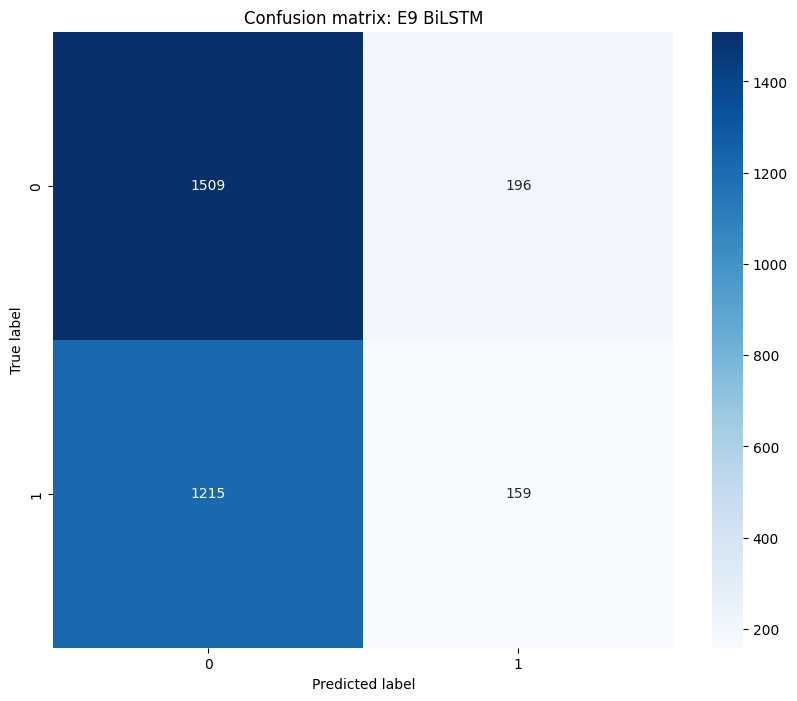

              precision    recall  f1-score   support

           0       0.55      0.89      0.68      1705
           1       0.45      0.12      0.18      1374

    accuracy                           0.54      3079
   macro avg       0.50      0.50      0.43      3079
weighted avg       0.51      0.54      0.46      3079



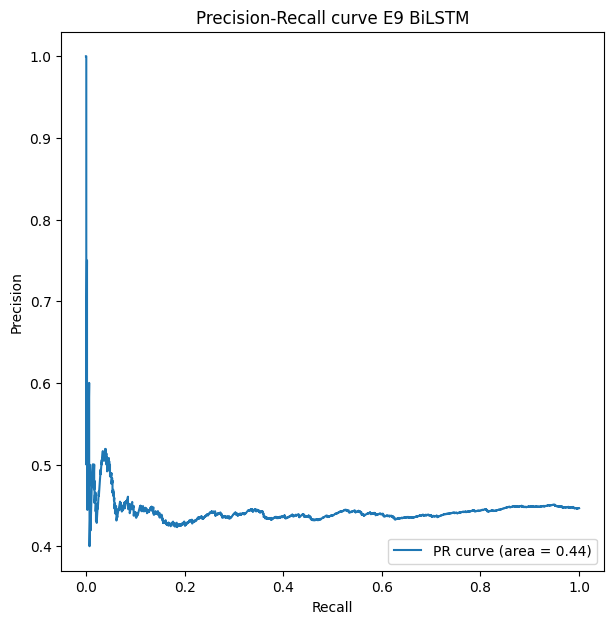

In [ ]:
###### BILSTM ######
# Load the saved model
model = load_model('best_model_domain_v2.h5')

# Assume you have your test data in X_test and y_test
y_test = vote_labels_test

# Predict the classes
y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E9 BiLSTM')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E9 BiLSTM')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 9 - BiLSTM to the results list (just one example)
stats.append(('9', 'BiLSTM', 'Domain', 'Vote', accuracy, precision, recall, f1, vote_majority))

97/97 [==============================] - 0s 2ms/step


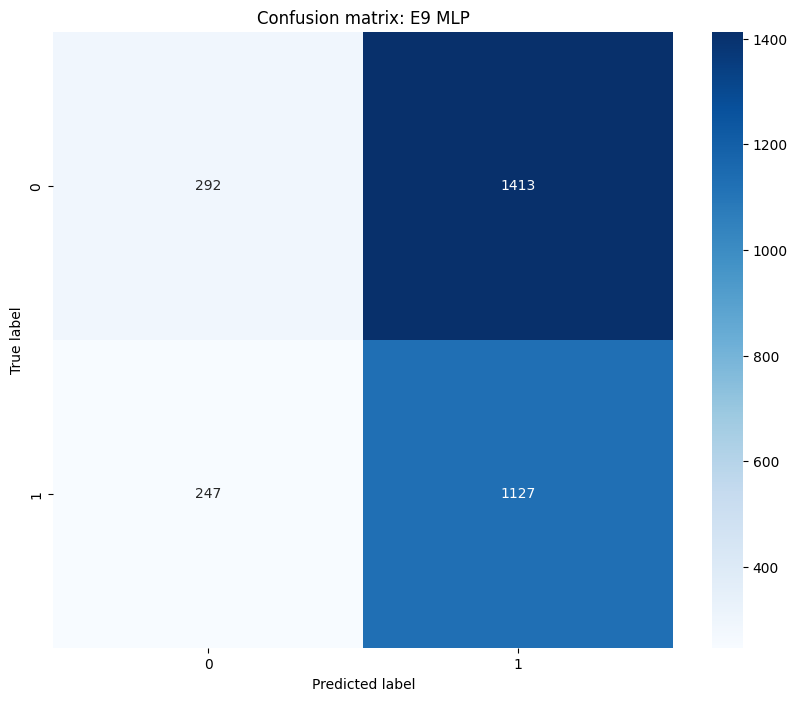

              precision    recall  f1-score   support

           0       0.54      0.17      0.26      1705
           1       0.44      0.82      0.58      1374

    accuracy                           0.46      3079
   macro avg       0.49      0.50      0.42      3079
weighted avg       0.50      0.46      0.40      3079



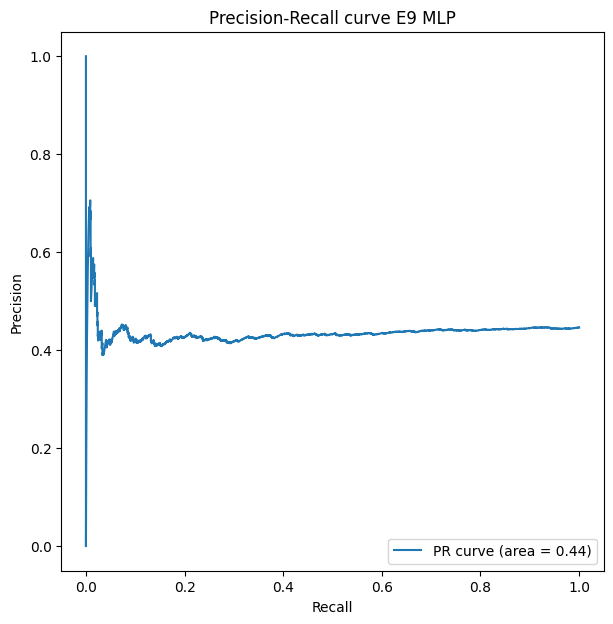

In [ ]:
##### EVALUATE MLP #####
mlp_domain = Sequential([
    Dense(100, input_shape=(data.shape[1],)),  # Hidden layer of 100 nodes
    BatchNormalization(),  # Batch normalization
    Activation('relu'),  # ReLU activation function
    Dropout(0.5),  # Dropout regularization rate of 0.5
    Dense(domain_labels.shape[1], activation='sigmoid')  # Sigmoid activation in the output layer
])

mlp_domain.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
mlp_domain.fit(data, domain_labels, batch_size=32, epochs=10, verbose=1, validation_data=(x_val, vote_labels_val))

# Test labels, X_train = data is already defined
y_test = vote_labels_test

# Predict the classes
y_pred = mlp_domain.predict(X_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis=1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test, axis=1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: E9 MLP')
plt.show()

# Print the classification report
print(classification_report(y_true, y_pred_classes))

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred[:,1])
plt.figure(figsize=(7,7))
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve E9 MLP')
plt.legend(loc="lower right")
plt.show()

# Compute the metrics and store them in variables
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Add the results for Experiment 7 - MLP to the results list (just one example)
stats.append(('9', 'MLP', 'Domain', 'Vote', accuracy, precision, recall, f1, vote_majority))

In [ ]:
#### SVM #####
accuracy, precision, recall, f1 = svm_pipeline(
    data=pv['speech_svm'],
    train_labels=domain_labels,
    test_labels=vote_labels,
    name='Experiment 6 SVM'
)

# Add the results to the results list
stats.append(('9', 'SVM', 'Domain', 'Vote', accuracy, precision, recall, f1, vote_majority))

              precision    recall  f1-score   support

           0       0.55      0.28      0.37      1425
           1       0.41      0.69      0.52      1039

    accuracy                           0.45      2464
   macro avg       0.48      0.49      0.44      2464
weighted avg       0.49      0.45      0.43      2464

Accuracy: 45.37%
Precision: 41.19%
Recall: 69.10%
F1-score: 51.62%


SAVE RESULTS

In [ ]:
## When multiple experiments have been added, write the results to the CSV file
with open(filename, 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header)
    writer.writerows(stats)

In [ ]:
ff2 = pd.read_csv('HPO -Final Run-/hpo_experiment_results.csv')
ff2

,Experiment,Model,Train label,Test label,Accuracy,Precision,Recall,F1,Majority baseline
0,1,BiLSTM,Vote,Vote,0.5925925925925926,0.603921568627451,0.5925925925925926,0.5974937343358396,0.6666666666666666
1,1,MLP,Vote,Vote,0.6296296296296297,0.6095238095238095,0.6296296296296297,0.6162280701754385,0.6666666666666666
2,1,SVM,Vote,Vote,0.45454545454545453,0.3333333333333333,0.5,0.4,0.6666666666666666
3,2,BiLSTM,VADER,VADER,0.8148148148148148,0.6639231824417009,0.8148148148148148,0.7316704459561602,0.8148148148148148
4,2,MLP,VADER,VADER,0.8148148148148148,0.6639231824417009,0.8148148148148148,0.7316704459561602,0.8148148148148148
...,...,...,...,...,...,...,...,...,...
78,8,MLP,Domain,Domain,0.8639168561221175,0.8572306674675455,0.8639168561221175,0.8587104953113692,0.7856446898343618
79,8,SVM,Domain,Domain,0.6152597402597403,0.7762478485370051,0.7080062794348508,0.7405582922824302,0.7856446898343618
80,9,BiLSTM,Domain,Vote,0.5417343293277038,0.5066278320860229,0.5417343293277038,0.4594106819413082,0.5537512179278987
81,9,MLP,Domain,Vote,0.4608639168561221,0.4979923193496327,0.4608639168561221,0.40109990391230976,0.5537512179278987


In [ ]:
ffopen = pd.read_csv(filename)
for row, column in ffopen:
    print(row)

FileNotFoundError: [Errno 2] No such file or directory: 'hpo_experiment_results.csv'

In [ ]:
combined_df['best_param']

model     original_index
vote      0                 {"lstm_units": 64, "learning_rate": 0.00072237...
vader     0                 {"lstm_units": 128, "learning_rate": 4.0280553...
textblob  0                 {"lstm_units": 64, "learning_rate": 0.00736081...
afinn     0                 {"lstm_units": 64, "learning_rate": 0.00980714...
Name: best_param, dtype: object

In [ ]:
###### BREAK #########
if 1 == 1:
    raise ValueError("Stopping execution at this cell")

ValueError: Stopping execution at this cell

# OUDE OPZET

In [ ]:
pv = backup

In [ ]:

def sentiment_analysis_pipeline(data, train_labels, test_labels, lstm_units, spatial_dropout_rate, name, dense_units, learning_rate, batch_size, epochs, input_dropout_rate, recurrent_dropout_rate, output_dropout_rate, smote, use_kfold, test_size=0.2, n_splits=5):
    data = np.stack(data, axis=0)  # Convert the lists of embeddings to a NumPy array
    
    if use_kfold:
        # K-fold cross-validation
        kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        splits = kfold.split(data, np.argmax(train_labels, axis=1))
    else:
        train_data, test_data, train_labels, _ = train_test_split(data, train_labels, test_size=test_size, stratify=vote_labels, random_state=42)
        test_labels = test_labels[len(train_labels):]
        splits = [(range(len(train_data)), range(len(test_data)))]

    # Store evaluation scores for each fold or train-test split
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for train_index, test_index in splits:
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = train_labels[train_index], test_labels[test_index]

        # Create the SMOTE instance if specified
        if smote:
            smote_sampler = SMOTE(random_state=42)
            X_train, y_train = smote_sampler.fit_resample(X_train, y_train)

        # Define the model
        model = models.Sequential([
            layers.Input(shape=(X_train.shape[1],)),
            layers.Reshape((1, X_train.shape[1])),
            layers.SpatialDropout1D(spatial_dropout_rate),
            layers.Bidirectional(layers.LSTM(lstm_units, dropout=input_dropout_rate, recurrent_dropout=recurrent_dropout_rate)),
            layers.Dense(dense_units, activation='relu'),
            layers.Dropout(output_dropout_rate),
            layers.Dense(y_train.shape[1], activation='softmax')
        ])


        model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test))
        
        # Train the model
        model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1)

        # Predict on test data
        y_pred = np.argmax(model.predict(X_test), axis=-1)
        y_test_decoded = np.argmax(y_test, axis=-1)

        train_val_name = 'Train-Validation Loss: ' + name
        # Plot training and validation loss
        plt.figure(figsize=(12, 4))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(train_val_name)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Compute the confusion matrix
        confusion_mtx = confusion_matrix(y_test_decoded, y_pred)

        cf_name = 'Confusion Matrix: ' + name 
         # Plot the confusion matrix
        plt.figure(figsize=(10,8))
        sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title(cf_name)
        plt.show()

        # Print the classification report
        print(classification_report(y_test_decoded, y_pred))

        pr_name = 'Precision-Recall curve: ' + name
        # Plot Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_test_decoded, y_pred)
        plt.figure(figsize=(7,7))
        plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(pr_name)
        plt.legend(loc="lower right")
        plt.show()

        # Evaluation
        accuracy = accuracy_score(y_test_decoded, y_pred)
        precision = precision_score(y_test_decoded, y_pred, average='weighted')
        recall = recall_score(y_test_decoded, y_pred, average='weighted')
        f1 = f1_score(y_test_decoded, y_pred, average='weighted')

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    # Print average scores
    print(f"Average accuracy: {np.mean(accuracies):.2%}")
    print(f"Average precision: {np.mean(precisions):.2%}")
    print(f"Average recall: {np.mean(recalls):.2%}")
    print(f"Average F1-score: {np.mean(f1_scores):.2%}")
    accuracy = np.mean(accuracies)
    precision = np.mean(precisions)
    recall = np.mean(recalls)
    f1 = np.mean(f1_scores)
    return accuracy, precision, recall, f1


def mlp_baseline_pipeline(data, train_labels, test_labels, smote, use_kfold, name, test_size=0.2, n_splits=5, dense_units=100, learning_rate=1e-3, batch_size=32, epochs=10):
    data = np.stack(data, axis=0)  # Convert the lists of embeddings to a NumPy array
    if use_kfold:
        kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        splits = kfold.split(data, np.argmax(train_labels, axis=1))
    else:
        train_data, test_data, train_labels, _ = train_test_split(data, train_labels, test_size=test_size, stratify=vote_labels, random_state=42)
        test_labels = test_labels[len(train_labels):]
        splits = [(range(len(train_data)), range(len(test_data)))]

    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for train_index, test_index in splits:
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = train_labels[train_index], test_labels[test_index]

        if smote:
            smote_sampler = SMOTE(random_state=42)
            X_train, y_train = smote_sampler.fit_resample(X_train, y_train)

        model = Sequential([
            Dense(dense_units, input_shape=(X_train.shape[1],)),  # Hidden layer of 100 nodes
            BatchNormalization(),  # Batch normalization
            Activation('relu'),  # ReLU activation function
            Dropout(0.5),  # Dropout regularization rate of 0.5
            Dense(y_train.shape[1], activation='sigmoid')  # Sigmoid activation in the output layer
        ])

        model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test))
        model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1)

        y_pred = np.argmax(model.predict(X_test), axis=-1)
        y_test_decoded = np.argmax(y_test, axis=-1)

        train_val_name = 'Train-Validation Loss: ' + name
        #PLOTTING
        # Plot training and validation loss
        plt.figure(figsize=(12, 4))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(train_val_name)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Compute the confusion matrix
        confusion_mtx = confusion_matrix(y_test_decoded, y_pred)
        
        cf_name = 'Confusion Matrix: ' + name 

         # Plot the confusion matrix
        plt.figure(figsize=(10,8))
        sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title(cf_name)
        plt.show()

        # Print the classification report
        print(classification_report(y_test_decoded, y_pred))

        pr_name = 'Precision-Recall curve: ' + name
        # Plot Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_test_decoded, y_pred)
        plt.figure(figsize=(7,7))
        plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(pr_name)
        plt.legend(loc="lower right")
        plt.show()


        #EVALUATION METRICS
        accuracy = accuracy_score(y_test_decoded, y_pred)
        precision = precision_score(y_test_decoded, y_pred, average='weighted')
        recall = recall_score(y_test_decoded, y_pred, average='weighted')
        f1 = f1_score(y_test_decoded, y_pred, average='weighted')

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    print(f"Average accuracy: {np.mean(accuracies):.2%}")
    print(f"Average precision: {np.mean(precisions):.2%}")
    print(f"Average recall: {np.mean(recalls):.2%}")
    print(f"Average F1-score: {np.mean(f1_scores):.2%}")
    accuracy = np.mean(accuracies)
    precision = np.mean(precisions)
    recall = np.mean(recalls)
    f1 = np.mean(f1_scores)
    return accuracy, precision, recall, f1



# ##### LOGISTIC REGRESSION #######
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import average_precision_score

# def logistic_regression_pipeline(data, train_labels, test_labels, smote, use_kfold, name, test_size=0.2, n_splits=5):
#     data = np.stack(data, axis=0)  # Convert the lists of embeddings to a NumPy array
#     le = LabelEncoder()
#     train_labels_encoded = le.fit_transform(np.argmax(train_labels, axis=1))
#     test_labels_encoded = le.transform(np.argmax(test_labels, axis=1))
#     if use_kfold:
#         kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
#         splits = kfold.split(data, train_labels_encoded)
#     else:
#         train_data, test_data, train_labels, _ = train_test_split(data, train_labels_encoded, test_size=test_size, stratify=train_labels_encoded, random_state=42)
#         test_labels = test_labels_encoded[len(train_labels):]
#         splits = [(range(len(train_data)), range(len(test_data)))]

#     accuracies = []
#     precisions = []
#     recalls = []
#     f1_scores = []

#     for train_index, test_index in splits:
#         X_train, X_test = data[train_index], data[test_index]
#         y_train, y_test = train_labels[train_index], test_labels[test_index]

#         if smote:
#             smote_sampler = SMOTE(random_state=42)
#             X_train, y_train = smote_sampler.fit_resample(X_train, y_train)

#         model = LogisticRegression(random_state=42, max_iter=1000)
#         model.fit(X_train, y_train)

#         y_pred = model.predict(X_test)

#         # Compute the confusion matrix
#         confusion_mtx = confusion_matrix(y_test, y_pred)
        
#         cf_name = 'Confusion Matrix: ' + name 

#          # Plot the confusion matrix
#         plt.figure(figsize=(10,8))
#         sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap='Blues')
#         plt.xlabel('Predicted label')
#         plt.ylabel('True label')
#         plt.title(cf_name)
#         plt.show()

#         # Print the classification report
#         print(classification_report(y_test, y_pred))

#         pr_name = 'Precision-Recall curve: ' + name
#         # Plot Precision-Recall curve
#         precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])
#         plt.figure(figsize=(7,7))
#         plt.plot(recall, precision, label='PR curve (area = %0.2f)' % auc(recall, precision))
#         plt.xlabel('Recall')
#         plt.ylabel('Precision')
#         plt.title(pr_name)
#         plt.legend(loc="lower right")
#         plt.show()

#         #EVALUATION METRICS
#         accuracy = accuracy_score(y_test, y_pred)
#         precision = precision_score(y_test, y_pred, average='weighted')
#         recall = recall_score(y_test, y_pred, average='weighted')
#         f1 = f1_score(y_test, y_pred, average='weighted')

#         accuracies.append(accuracy)
#         precisions.append(precision)
#         recalls.append(recall)
#         f1_scores.append(f1)

#     print(f"Average accuracy: {np.mean(accuracies):.2%}")
#     print(f"Average precision: {np.mean(precisions):.2%}")
#     print(f"Average recall: {np.mean(recalls):.2%}")
#     print(f"Average F1-score: {np.mean(f1_scores):.2%}")
#     accuracy = np.mean(accuracies)
#     precision = np.mean(precisions)
#     recall = np.mean(recalls)
#     f1 = np.mean(f1_scores)
#     return accuracy, precision, recall, f1


# ##### SVM FUNCTION #####
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.pipeline import Pipeline
# from sklearn.svm import SVC
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# from sklearn.preprocessing import LabelEncoder

# def svm_pipeline(data, train_labels, test_labels, name, test_size=0.2):
    
#     train_data, test_data, train_labels, _ = train_test_split(data, train_labels, test_size=test_size, stratify=vote_labels, random_state=42)
#     test_labels = test_labels[len(train_labels):]
#     splits = [(range(len(train_data)), range(len(test_data)))]
    
#     accuracies = []
#     precisions = []
#     recalls = []
#     f1_scores = []
    
#     # It's a binary classification, LabelEncoder is used instead of LabelBinarizer
#     train_labels = np.argmax(train_labels, axis=1)
#     test_labels = np.argmax(test_labels, axis=1)
#     le = LabelEncoder()
#     train_labels = le.fit_transform(train_labels)
#     test_labels = le.transform(test_labels)

#     #data = data.values
#     # Define the pipeline
#     pipeline = Pipeline([
#         ('tfidf', TfidfVectorizer(max_df=0.9, min_df=5)),
#         ('clf', SVC(kernel='linear', probability=True, class_weight='balanced'))
#     ])

#     # Train the SVM classifier
#     pipeline.fit(train_data, train_labels)

#     y_pred = pipeline.predict(test_data)

#     #EVALUATION METRICS
#     accuracy = accuracy_score(test_labels, y_pred)
#     precision = precision_score(test_labels, y_pred)
#     recall = recall_score(test_labels, y_pred)
#     f1 = f1_score(test_labels, y_pred)
    
#     # Print the classification report
#     print(classification_report(test_labels, y_pred))

#     print(f"Accuracy: {accuracy:.2%}")
#     print(f"Precision: {precision:.2%}")
#     print(f"Recall: {recall:.2%}")
#     print(f"F1-score: {f1:.2%}")

#     return accuracy, precision, recall, f1

###############################################################################################

# # Hyperparameter optimizations
# search_space = {
#     'lstm_units': [32, 64, 128],
#     'spatial_dropout_rate': [0.1, 0.2, 0.3],
#     'dense_units': [16, 32, 64],
#     'learning_rate': [1e-3, 1e-4],
#     'batch_size': [16, 32],
#     'epochs': [5, 10, 15], 
#     'smote' : [True, False], 
#     'use_kfold' : [True, False]
# }

# # Hyperparameter setup


# def generate_combinations(search_space):
#     keys, values = zip(*search_space.items())
#     return [dict(zip(keys, v)) for v in product(*values)]

# combinations = generate_combinations(search_space)

# # Hyperparamter optimization functie
# def run_pipeline_with_combination(combination, data, train_labels, test_labels):
#     return sentiment_analysis_pipeline(
#         data=data,
#         train_labels=train_labels,
#         test_labels=test_labels,
#         smote=combination['smote'],
#         use_kfold=combination['use_kfold'],
#         lstm_units=combination['lstm_units'],
#         spatial_dropout_rate=combination['spatial_dropout_rate'],
#         dense_units=combination['dense_units'],
#         learning_rate=combination['learning_rate'],
#         batch_size=combination['batch_size'],
#         epochs=combination['epochs']
#     )

# # Define the filename for the CSV file
# filename = 'experiment_results.csv'

# # Define the header for the CSV file
# header = ['Experiment', 'Parameters', 'F1-score']

# # Initialize an empty list to store the results
# results = []

# # Hyperparameter optimization Experiment 1 
# best_combination_exp_1 = None
# best_f1_exp_1 = -1

# for combination in combinations:
#     f1_exp_1 = run_pipeline_with_combination(combination, data=pv['embeddings'], train_labels=vote_labels, test_labels=vote_labels)
    
#     if f1_exp_1 > best_f1_exp_1:
#         best_f1_exp_1 = f1_exp_1
#         best_combination_exp_1 = combination

# print(f"Best combination experiment 1: {best_combination_exp_1}")
# print(f"Best F1-score experiment 1: {best_f1_exp_1}")

# # Add the results for Experiment 1 to the results list
# results.append(('Experiment 1', best_combination_exp_1, best_f1_exp_1))

# # Hyperparameter optimization Experiment 2 
# best_combination_exp_2 = None
# best_f1_exp_2 = -1

# for combination in combinations:
#     f1_exp_2 = run_pipeline_with_combination(combination, data=pv['embeddings'], train_labels=vader_labels, test_labels=vader_labels)
    
#     if f1_exp_2 > best_f1_exp_2:
#         best_f1_exp_2 = f1_exp_2
#         best_combination_exp_2 = combination

# print(f"Best combination experiment 2: {best_combination_exp_2}")
# print(f"Best F1-score experiment 2: {best_f1_exp_2}")

# # Add the results for Experiment 2 to the results list
# results.append(('Experiment 2', best_combination_exp_2, best_f1_exp_2))

# # Hyperparameter optimization Experiment 3 
# best_combination_exp_3 = None
# best_f1_exp_3 = -1

# for combination in combinations:
#     f1_exp_3 = run_pipeline_with_combination(combination, data=pv['embeddings'], train_labels=vader_labels, test_labels=vote_labels)
    
#     if f1_exp_3 > best_f1_exp_3:
#         best_f1_exp_3 = f1_exp_3
#         best_combination_exp_3 = combination

# print(f"Best combination experiment 3: {best_combination_exp_3}")
# print(f"Best F1-score experiment 3: {best_f1_exp_3}")

# # Add the results for Experiment 3 to the results list
# results.append(('Experiment 3', best_combination_exp_3, best_f1_exp_3))

# # Hyperparameter optimization Experiment 4 
# best_combination_exp_4 = None
# best_f1_exp_4 = -1

# for combination in combinations:
#     f1_exp_4 = run_pipeline_with_combination(combination, data=pv['embeddings'], train_labels=textblob_labels, test_labels=textblob_labels)
    
#     if f1_exp_4 > best_f1_exp_4:
#         best_f1_exp_4 = f1_exp_4
#         best_combination_exp_4 = combination

# print(f"Best combination experiment 4: {best_combination_exp_4}")
# print(f"Best F1-score experiment 4: {best_f1_exp_4}")

# # Add the results for Experiment 4 to the results list
# results.append(('Experiment 4', best_combination_exp_4, best_f1_exp_4))

# # Hyperparameter optimization Experiment 5
# best_combination_exp_5 = None
# best_f1_exp_5 = -1

# for combination in combinations:
#     f1_exp_5 = run_pipeline_with_combination(combination, data=pv['embeddings'], train_labels=textblob_labels, test_labels=vote_labels)
    
#     if f1_exp_5 > best_f1_exp_5:
#         best_f1_exp_5 = f1_exp_5
#         best_combination_exp_5 = combination

# print(f"Best combination experiment 5: {best_combination_exp_5}")
# print(f"Best F1-score experiment 5: {best_f1_exp_5}")

# # Add the results for Experiment 5 to the results list
# results.append(('Experiment 5', best_combination_exp_5, best_f1_exp_5))

# # Hyperparameter optimization Experiment 6 
# best_combination_exp_6 = None
# best_f1_exp_6 = -1

# for combination in combinations:
#     f1_exp_6 = run_pipeline_with_combination(combination, data=pv['embeddings'], train_labels=afinn_labels, test_labels=afinn_labels)
    
#     if f1_exp_6 > best_f1_exp_6:
#         best_f1_exp_6 = f1_exp_6
#         best_combination_exp_6 = combination

# print(f"Best combination experiment 6: {best_combination_exp_6}")
# print(f"Best F1-score experiment 6: {best_f1_exp_6}")

# # Add the results for Experiment 6 to the results list
# results.append(('Experiment 6', best_combination_exp_6, best_f1_exp_6))

# # Hyperparameter optimization Experiment 7 
# best_combination_exp_7 = None
# best_f1_exp_7 = -1

# for combination in combinations:
#     f1_exp_7 = run_pipeline_with_combination(combination, data=pv['embeddings'], train_labels=afinn_labels, test_labels=vote_labels)
    
#     if f1_exp_7 > best_f1_exp_7:
#         best_f1_exp_7 = f1_exp_7
#         best_combination_exp_7 = combination

# print(f"Best combination experiment 7: {best_combination_exp_7}")
# print(f"Best F1-score experiment 7: {best_f1_exp_7}")

# # Add the results for Experiment 7 to the results list
# results.append(('Experiment 7', best_combination_exp_7, best_f1_exp_7))

# # Write the results to the CSV file
# with open(filename, 'a', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerow(header)
#     writer.writerows(results)


###############################################################################################

# Experiments with best parameters
# Define the filename for the CSV file
filename_2 = 'best_experiment_results.csv'

# Define the header for the CSV file
header_2 = ['Experiment', 'Model', 'Train label', 'Test label', 'Accuracy', 'Precision', 'Recall', 'F1', 'Majority baseline', 'Parameters']

bilstm_parameters_human = "kfold=False, LSTM_units = 64, \n spatial_dropout = 0.3, \n dense_units = 64, \n 'learning_rate = 0.001, \n batch_size=100, \n epochs=10, \n  input_dropout_rate=0.3, \n recurrent_dropout_rate=0.3, \n output_dropout_rate=0.4"
bilstm_parameters_auto = "kfold=False, LSTM_units = 64, \n spatial_dropout = 0.2, \n dense_units = 64, \n 'learning_rate = 0.001, \n batch_size=100, \n epochs=10, \n  input_dropout_rate=0.2, \n recurrent_dropout_rate=0.2, \n output_dropout_rate=0.5"
bilstm_parameters_mix = "kfold=False, LSTM_units = 64, \n spatial_dropout = 0.3, \n dense_units = 64, \n 'learning_rate = 0.001, \n batch_size=100, \n epochs=10, \n  input_dropout_rate=0.3, \n recurrent_dropout_rate=0.3, \n output_dropout_rate=0.5"
mlp_parameters = 'Standard'


# Initialize an empty list to store the results
results_2 = []


## Experiment 1 
accuracy, precision, recall, f1 = sentiment_analysis_pipeline(
        data=pv['embeddings'],
        train_labels=vote_labels,
        test_labels=vote_labels,
        smote=False,
        use_kfold=False,
        lstm_units=64,
        spatial_dropout_rate=0.3,
        dense_units=64,
        learning_rate=0.0001,
        batch_size=100,
        epochs=10,
        input_dropout_rate=0.3, 
        recurrent_dropout_rate=0.3, 
        output_dropout_rate=0.4,
        name='Experiment 1 BiLSTM'
)


# Add the results for Experiment 1 - BiLSTM to the results list
results_2.append(('1', 'BiLSTM', 'Vote', 'Vote', accuracy, precision, recall, f1, vote_majority, bilstm_parameters_human))

accuracy, precision, recall, f1 = mlp_baseline_pipeline(
    data=pv['embeddings'],
    train_labels=vote_labels,
    test_labels=vote_labels,
    test_size=0.2,
    n_splits=5,  
    learning_rate=0.0001,
    batch_size=32,
    epochs=10, 
    smote=False, 
    use_kfold=False, 
    name='Experiment 1 MLP'
)


# Add the results for Experiment 1 - MLP baseline to the results list
results_2.append(('1', 'MLP', 'Vote', 'Vote', accuracy, precision, recall, f1, vote_majority, mlp_parameters))


## Experiment 2
accuracy, precision, recall, f1 = sentiment_analysis_pipeline(
        data=pv['embeddings'],
        train_labels=vader_labels,
        test_labels=vader_labels,
        smote=False,
        use_kfold=False,
        lstm_units=64,
        spatial_dropout_rate=0.2,
        dense_units=64,
        learning_rate=0.001,
        batch_size=100,
        epochs=10,
        input_dropout_rate=0.2, 
        recurrent_dropout_rate=0.2, 
        output_dropout_rate=0.5,
        name='Experiment 2 BiLSTM'
)


# Add the results for Experiment 2 - BiLSTM to the results list
results_2.append(('2', 'BiLSTM', 'VADER', 'VADER', accuracy, precision, recall, f1, vader_majority, bilstm_parameters_auto))

accuracy, precision, recall, f1 = mlp_baseline_pipeline(
    data=pv['embeddings'],
    train_labels=vader_labels,
    test_labels=vader_labels,
    test_size=0.2,
    n_splits=5,  
    learning_rate=0.001,
    batch_size=32,
    epochs=10, 
    smote=False, 
    use_kfold=False,
    name='Experiment 2 MLP'
)


# Add the results for Experiment 2 - MLP baseline to the results list
results_2.append(('2', 'MLP', 'VADER', 'VADER', accuracy, precision, recall, f1, vader_majority, mlp_parameters))


## Experiment 3 
accuracy, precision, recall, f1 = sentiment_analysis_pipeline(
        data=pv['embeddings'],
        train_labels=vader_labels,
        test_labels=vote_labels,
        smote=False,
        use_kfold=False,
        lstm_units=64,
        spatial_dropout_rate=0.3,
        dense_units=64,
        learning_rate=0.001,
        batch_size=100,
        epochs=10,
        input_dropout_rate=0.3, 
        recurrent_dropout_rate=0.3, 
        output_dropout_rate=0.5,
        name='Experiment 3 BiLSTM'
)

# Add the results for Experiment 3 - BiLSTM to the results list
results_2.append(('3', 'BiLSTM', 'VADER', 'Vote', accuracy, precision, recall, f1, vote_majority, bilstm_parameters_mix))

accuracy, precision, recall, f1 = mlp_baseline_pipeline(
    data=pv['embeddings'],
    train_labels=vader_labels,
    test_labels=vote_labels,
    test_size=0.2,
    n_splits=5,  
    learning_rate=0.001,
    batch_size=32,
    epochs=10, 
    smote=False, 
    use_kfold=False,
    name='Experiment 3 MLP'
)

# Add the results for Experiment 3 - MLP baseline to the results list
results_2.append(('3', 'MLP', 'VADER', 'Vote', accuracy, precision, recall, f1, vote_majority, mlp_parameters))


## Experiment 4 
accuracy, precision, recall, f1 = sentiment_analysis_pipeline(
        data=pv['embeddings'],
        train_labels=textblob_labels,
        test_labels=textblob_labels,
        smote=False,
        use_kfold=False,
        lstm_units=64,
        spatial_dropout_rate=0.2,
        dense_units=64,
        learning_rate=0.001,
        batch_size=100,
        epochs=10,
        input_dropout_rate=0.2, 
        recurrent_dropout_rate=0.2, 
        output_dropout_rate=0.5, 
        name='Experiment 4 BiLSTM'
)

# Add the results for Experiment 4 - BiLSTM to the results list
results_2.append(('4', 'BiLSTM', 'TextBlob', 'TextBlob', accuracy, precision, recall, f1, textblob_majority, bilstm_parameters_auto))

accuracy, precision, recall, f1 = mlp_baseline_pipeline(
    data=pv['embeddings'],
    train_labels=textblob_labels,
    test_labels=textblob_labels,
    test_size=0.2,
    n_splits=5,  
    learning_rate=0.001,
    batch_size=32,
    epochs=10, 
    smote=False, 
    use_kfold=False, 
    name='Experiment 4 MLP'
)

# Add the results for Experiment 4 - MLP baseline to the results list
results_2.append(('4', 'MLP', 'TextBlob', 'TextBlob', accuracy, precision, recall, f1, textblob_majority, mlp_parameters))


## Experiment 5 
accuracy, precision, recall, f1 = sentiment_analysis_pipeline(
        data=pv['embeddings'],
        train_labels=textblob_labels,
        test_labels=vote_labels,
        smote=False,
        use_kfold=False,
        lstm_units=64,
        spatial_dropout_rate=0.3,
        dense_units=64,
        learning_rate=0.001,
        batch_size=100,
        epochs=10,
        input_dropout_rate=0.3, 
        recurrent_dropout_rate=0.3, 
        output_dropout_rate=0.5, 
        name='Experiment 5 BiLSTM'
)

# Add the results for Experiment 5 - BiLSTM to the results list
results_2.append(('5', 'BiLSTM', 'TextBlob', 'Vote', accuracy, precision, recall, f1, vote_majority, bilstm_parameters_mix))

accuracy, precision, recall, f1 = mlp_baseline_pipeline(
    data=pv['embeddings'],
    train_labels=textblob_labels,
    test_labels=vote_labels,
    test_size=0.2,
    n_splits=5,  
    learning_rate=0.001,
    batch_size=32,
    epochs=10, 
    smote=False, 
    use_kfold=False, 
    name='Experiment 5 MLP'
)

# Add the results for Experiment 5 - MLP baseline to the results list
results_2.append(('5', 'MLP', 'TextBlob', 'Vote', accuracy, precision, recall, f1, vote_majority, mlp_parameters))


## Experiment 6 
accuracy, precision, recall, f1 = sentiment_analysis_pipeline(
        data=pv['embeddings'],
        train_labels=afinn_labels,
        test_labels=afinn_labels,
        smote=False,
        use_kfold=False,
        lstm_units=64,
        spatial_dropout_rate=0.2,
        dense_units=64,
        learning_rate=0.001,
        batch_size=100,
        epochs=10,
        input_dropout_rate=0.2, 
        recurrent_dropout_rate=0.2, 
        output_dropout_rate=0.5, 
        name='Experiment 6 BiLSTM'
)

# Add the results for Experiment 6 - BiLSTM to the results list
results_2.append(('6', 'BiLSTM', 'Afinn', 'Afinn', accuracy, precision, recall, f1, afinn_majority, bilstm_parameters_auto))

accuracy, precision, recall, f1 = mlp_baseline_pipeline(
    data=pv['embeddings'],
    train_labels=afinn_labels,
    test_labels=afinn_labels,
    test_size=0.2,
    n_splits=5,  
    learning_rate=0.001,
    batch_size=32,
    epochs=10, 
    smote=False, 
    use_kfold=False, 
    name='Experiment 6 MLP'
)

# Add the results for Experiment 6 - MLP baseline to the results list
results_2.append(('6', 'MLP', 'Afinn', 'Afinn', accuracy, precision, recall, f1, afinn_majority, mlp_parameters))

## Experiment 7 
accuracy, precision, recall, f1 = sentiment_analysis_pipeline(
        data=pv['embeddings'],
        train_labels=afinn_labels,
        test_labels=vote_labels,
        smote=False,
        use_kfold=False,
        lstm_units=64,
        spatial_dropout_rate=0.3,
        dense_units=64,
        learning_rate=0.001,
        batch_size=100,
        epochs=10,
        input_dropout_rate=0.3, 
        recurrent_dropout_rate=0.3, 
        output_dropout_rate=0.5, 
        name='Experiment 7 BiLSTM'
)

# Add the results for Experiment 7 - BiLSTM to the results list
results_2.append(('7', 'BiLSTM', 'Afinn', 'Vote', accuracy, precision, recall, f1, vote_majority, bilstm_parameters_mix))

accuracy, precision, recall, f1 = mlp_baseline_pipeline(
    data=pv['embeddings'],
    train_labels=afinn_labels,
    test_labels=vote_labels,
    test_size=0.2,
    n_splits=5,  
    learning_rate=0.001,
    batch_size=32,
    epochs=10, 
    smote=False, 
    use_kfold=False, 
    name='Experiment 7 MLP'
)

# Add the results for Experiment 7 - MLP baseline to the results list
results_2.append(('7', 'MLP', 'Afinn', 'Vote', accuracy, precision, recall, f1, vote_majority, mlp_parameters))

## Experiment 8 
accuracy, precision, recall, f1 = sentiment_analysis_pipeline(
        data=pv['embeddings'],
        train_labels=domain_labels,
        test_labels=domain_labels,
        smote=False,
        use_kfold=False,
        lstm_units=64,
        spatial_dropout_rate=0.2,
        dense_units=64,
        learning_rate=0.001,
        batch_size=100,
        epochs=10,
        input_dropout_rate=0.2, 
        recurrent_dropout_rate=0.2, 
        output_dropout_rate=0.5, 
        name='Experiment 8 BiLSTM'
)

# Add the results for Experiment 8 - BiLSTM to the results list
results_2.append(('8', 'BiLSTM', 'Domain', 'Domain', accuracy, precision, recall, f1, domain_majority, bilstm_parameters_auto))

accuracy, precision, recall, f1 = mlp_baseline_pipeline(
    data=pv['embeddings'],
    train_labels=domain_labels,
    test_labels=domain_labels,
    test_size=0.2,
    n_splits=5,  
    learning_rate=0.001,
    batch_size=32,
    epochs=10, 
    smote=False, 
    use_kfold=False, 
    name='Experiment 8 MLP'
)

# Add the results for Experiment 8 - MLP baseline to the results list
results_2.append(('8', 'MLP', 'Domain', 'Domain', accuracy, precision, recall, f1, domain_majority, mlp_parameters))


## Experiment 9 
accuracy, precision, recall, f1 = sentiment_analysis_pipeline(
        data=pv['embeddings'],
        train_labels=domain_labels,
        test_labels=vote_labels,
        smote=False,
        use_kfold=False,
        lstm_units=64,
        spatial_dropout_rate=0.3,
        dense_units=64,
        learning_rate=0.001,
        batch_size=100,
        epochs=10,
        input_dropout_rate=0.3, 
        recurrent_dropout_rate=0.3, 
        output_dropout_rate=0.5, 
        name='Experiment 9 BiLSTM'
)

# Add the results for Experiment 9 - BiLSTM to the results list
results_2.append(('9', 'BiLSTM', 'Domain', 'Vote', accuracy, precision, recall, f1, vote_majority, bilstm_parameters_mix))

accuracy, precision, recall, f1 = mlp_baseline_pipeline(
    data=pv['embeddings'],
    train_labels=domain_labels,
    test_labels=vote_labels,
    test_size=0.2,
    n_splits=5,  
    learning_rate=0.001,
    batch_size=32,
    epochs=10, 
    smote=False, 
    use_kfold=False, 
    name='Experiment 9 MLP'
)

# Add the results for Experiment 9 - MLP baseline to the results list
results_2.append(('9', 'MLP', 'Domain', 'Vote', accuracy, precision, recall, f1, vote_majority, mlp_parameters))


## Write the results to the CSV file
with open(filename_2, 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(header_2)
    writer.writerows(results_2)

ValueError: Found input variables with inconsistent numbers of samples: [135, 108]

In [ ]:
view = pd.read_csv(filename_2)
view

,Experiment,Model,Train label,Test label,Accuracy,Precision,Recall,F1,Majority baseline,Parameters
0,1,BiLSTM,Vote,Vote,0.573701,0.487154,0.573701,0.426456,0.553751,"kfold=False, LSTM_units = 64, \n spatial_dropo..."
1,1,MLP,Vote,Vote,0.497078,0.511295,0.497078,0.499872,0.553751,Standard
2,2,BiLSTM,VADER,VADER,0.792857,0.669415,0.792857,0.704472,0.772329,"kfold=False, LSTM_units = 64, \n spatial_dropo..."
3,2,MLP,VADER,VADER,0.727273,0.676956,0.727273,0.697878,0.772329,Standard
4,3,BiLSTM,VADER,Vote,0.575649,0.473252,0.575649,0.422256,0.553751,"kfold=False, LSTM_units = 64, \n spatial_dropo..."
5,3,MLP,VADER,Vote,0.561039,0.498859,0.561039,0.457724,0.553751,Standard
6,4,BiLSTM,TextBlob,TextBlob,0.847727,0.739070,0.847727,0.780563,0.835986,"kfold=False, LSTM_units = 64, \n spatial_dropo..."
7,4,MLP,TextBlob,TextBlob,0.830195,0.743464,0.830195,0.777381,0.835986,Standard
8,5,BiLSTM,TextBlob,Vote,0.576623,0.755929,0.576623,0.422128,0.553751,"kfold=False, LSTM_units = 64, \n spatial_dropo..."
9,5,MLP,TextBlob,Vote,0.574351,0.516435,0.574351,0.431737,0.553751,Standard


In [ ]:
token = pd.read_csv('removed_512.csv')
token

,original,>512 removed
0,"(33461, 11)","(18575, 12)"


In [ ]:
rem = pd.read_csv('removed_neutral.csv')
rem

,original,neutral removed
0,"(18575, 15)","(15396, 15)"


In [ ]:
perc = pd.read_csv('percentages.csv')
perc

,column,positive,negative
0,vote,54.163419,45.836581
1,vader,77.286308,22.713692
2,textblob,83.956872,16.043128
3,afinn,71.752403,28.247597


Epoch 1/10
385/385 [==============================] - 2s 4ms/step - loss: 0.7744 - accuracy: 0.6237 - val_loss: 1.1213 - val_accuracy: 0.4260
Epoch 2/10
385/385 [==============================] - 1s 4ms/step - loss: 0.5649 - accuracy: 0.7772 - val_loss: 1.5921 - val_accuracy: 0.4240
Epoch 3/10
385/385 [==============================] - 1s 4ms/step - loss: 0.5468 - accuracy: 0.7981 - val_loss: 1.4779 - val_accuracy: 0.4240
Epoch 4/10
385/385 [==============================] - 1s 3ms/step - loss: 0.5200 - accuracy: 0.8085 - val_loss: 1.3119 - val_accuracy: 0.4253
Epoch 5/10
385/385 [==============================] - 2s 4ms/step - loss: 0.5067 - accuracy: 0.8148 - val_loss: 1.4537 - val_accuracy: 0.4244
Epoch 6/10
385/385 [==============================] - 2s 4ms/step - loss: 0.4918 - accuracy: 0.8159 - val_loss: 1.3190 - val_accuracy: 0.4244
Epoch 7/10
385/385 [==============================] - 2s 4ms/step - loss: 0.4777 - accuracy: 0.8233 - val_loss: 1.2236 - val_accuracy: 0.4250
Epoch 

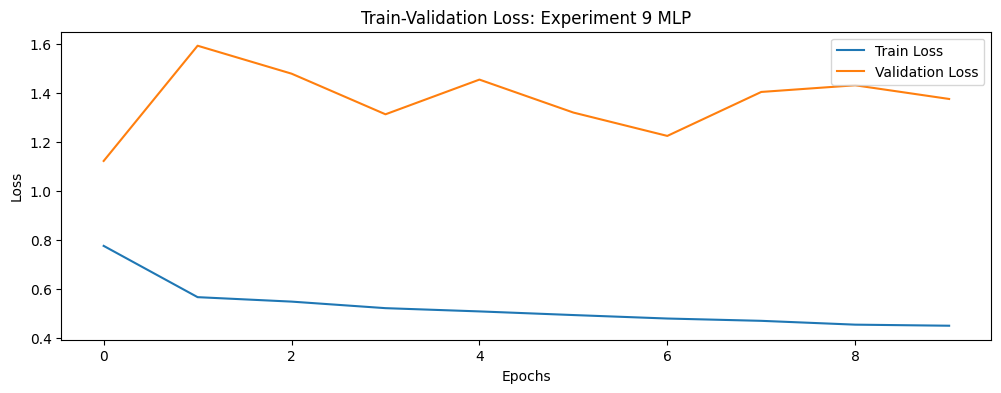

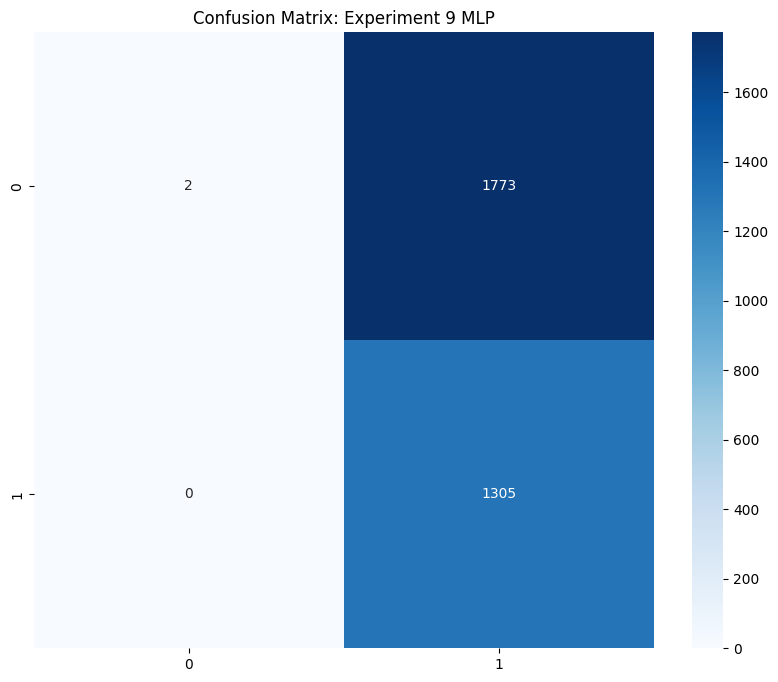

              precision    recall  f1-score   support

           0       1.00      0.00      0.00      1775
           1       0.42      1.00      0.60      1305

    accuracy                           0.42      3080
   macro avg       0.71      0.50      0.30      3080
weighted avg       0.76      0.42      0.25      3080



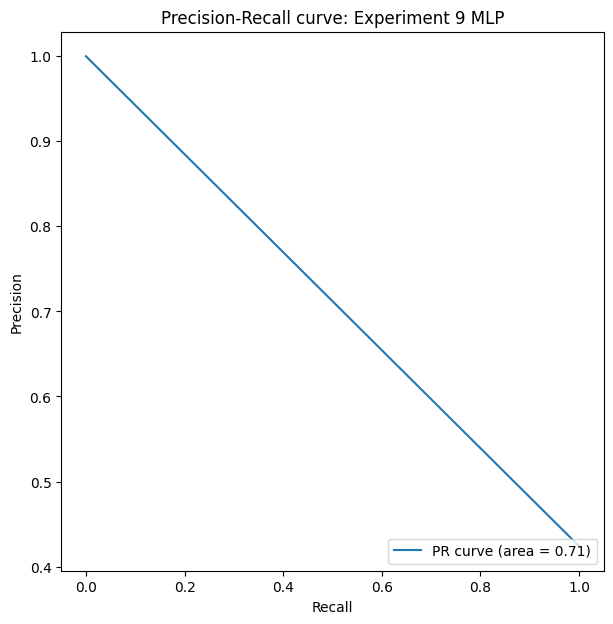

Average accuracy: 42.44%
Average precision: 75.59%
Average recall: 42.44%
Average F1-score: 25.36%


In [ ]:
accuracy, precision, recall, f1 = mlp_baseline_pipeline(
    data=pv['embeddings'],
    train_labels=domain_labels,
    test_labels=vote_labels,
    test_size=0.2,
    n_splits=5,  
    learning_rate=0.0001,
    batch_size=32,
    epochs=10, 
    smote=False, 
    use_kfold=False, 
    name='Experiment 9 MLP'
)

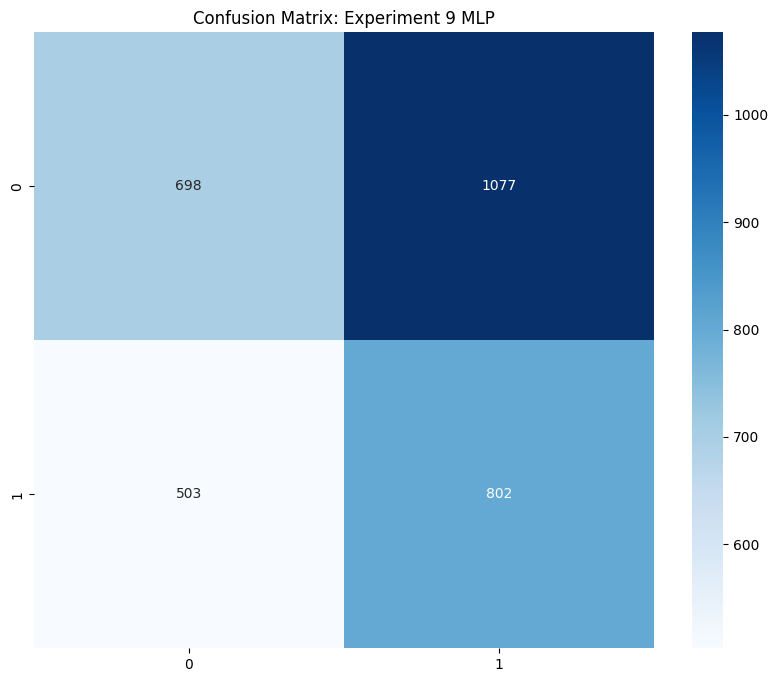

              precision    recall  f1-score   support

           0       0.58      0.39      0.47      1775
           1       0.43      0.61      0.50      1305

    accuracy                           0.49      3080
   macro avg       0.50      0.50      0.49      3080
weighted avg       0.52      0.49      0.48      3080



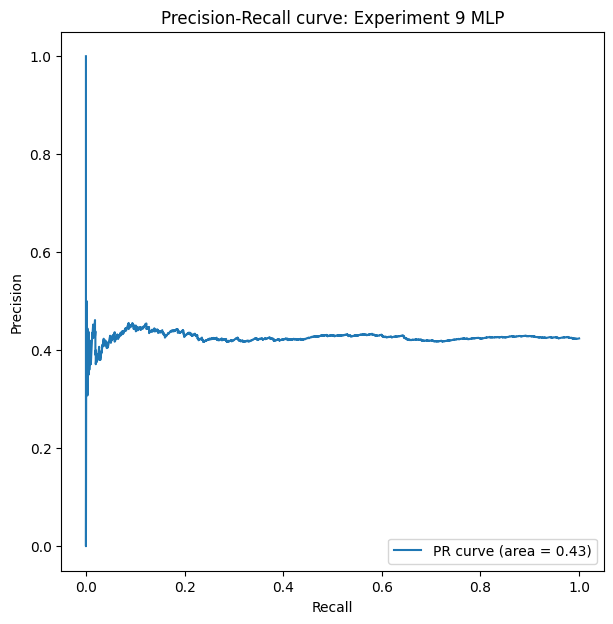

Average accuracy: 48.70%
Average precision: 51.58%
Average recall: 48.70%
Average F1-score: 48.38%


In [ ]:

accuracy, precision, recall, f1 = logistic_regression_pipeline(
    data=pv['embeddings'],
    train_labels=domain_labels,
    test_labels=vote_labels,
    test_size=0.2,
    n_splits=5,  
    smote=True, 
    use_kfold=False, 
    name='Experiment 9 MLP'
)


In [ ]:
pv['speech_svm'].shape

(108,)

In [ ]:
vader_labels.shape

(135, 2)

In [ ]:
accuracy, precision, recall, f1 = svm_pipeline(
    data=pv['speech_svm'],
    train_labels=vader_labels,
    test_labels=vote_labels,
    name='Experiment 9 SVM'
)

              precision    recall  f1-score   support

           0       0.62      0.71      0.67        14
           1       0.33      0.25      0.29         8

    accuracy                           0.55        22
   macro avg       0.48      0.48      0.48        22
weighted avg       0.52      0.55      0.53        22

Accuracy: 54.55%
Precision: 33.33%
Recall: 25.00%
F1-score: 28.57%
